<a href="https://colab.research.google.com/github/samer-glitch/Federated-Governance-and-Provenance-Scoring-for-Trustworthy-AI-A-Metadata-Ledger-Approach/blob/main/5_clients_15_global_rounds_Flower_runs_128_neurons_10_epoch_Centralized_training_local_training_2_epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pandas numpy scikit-learn matplotlib tensorflow "flwr[simulation]==1.18.0" seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.0/540.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 1.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyopenssl 24.2.1 requires cryptography<44,>=41.0.5, but you have cryptography 44.0.3 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 44.0.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you ha

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 0: IMPORTS & GLOBAL CONFIGURATION
# ──────────────────────────────────────────────────────────────────────────────
#!pip install -q pandas numpy scikit-learn matplotlib tensorflow "flwr[simulation]==1.18.0" seaborn

import os, io, glob, time, random, uuid, shutil
from datetime import datetime
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import tensorflow as tf
import flwr as fl

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix as sk_confusion_matrix
)

# Global Config
NUM_CLIENTS            = 5      # total distinct data-holding parties that will participate
RANDOM_STATE           = 42     # seed that keeps every shuffle/split reproducible
NUM_ROUNDS_FL          = 15     # how many server-client aggregation cycles the FL run performs
DEFAULT_LOCAL_EPOCHS   = 2      # how many full passes over each client’s local data *per round*
DEFAULT_CLIENT_FRACTION = 1.0   # 1.0 → every round the server selects **all** clients (no sampling)


# Carbon intensity (kg CO2 per kWh) – example global average
CARBON_INTENSITY = 0.475

# Client IDs & version counters
import string, itertools
single = list(string.ascii_uppercase)
double = [''.join(p) for p in itertools.product(string.ascii_uppercase, repeat=2)]
CLIENT_IDS = (single + double)[:NUM_CLIENTS]
version_counters = {}

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
tf.keras.utils.set_random_seed(RANDOM_STATE)
tf.get_logger().setLevel("ERROR")
print(f"TensorFlow: {tf.__version__}, Flower: {fl.__version__}")
# ──────────────────────────────────────────────────────────────────────────────
# Cell 1: ONE-TIME LEDGER INITIALIZATION
# ──────────────────────────────────────────────────────────────────────────────
# Wipe old ledgers & create folders
if os.path.exists("./ledgers"):
    shutil.rmtree("./ledgers")
os.makedirs("./ledgers/local", exist_ok=True)
os.makedirs("./ledgers/central", exist_ok=True)
print("⚠️ LEDGERS RESET: All previous ledger files will be deleted now. ⚠️")


# Empty central‐ledger with headers
pd.DataFrame(columns=[
    "tx_id","timestamp","client","version","record_count",
    "dim1_sub","dim2_sub","dim3_sub","dim4_sub","dim5_sub","dim6_sub",
    "pscore","action"
]).to_csv("./ledgers/central/central_ledger.csv", index=False)
# ──────────────────────────────────────────────────────────────────────────────
# Cell 2: DATA LOADING & INITIAL CLEAN-UP
# ──────────────────────────────────────────────────────────────────────────────
from google.colab import files
print("⬆️ Upload diabetes.csv")
uploaded = files.upload()
fname = next(iter(uploaded))
raw_df = pd.read_csv(io.BytesIO(uploaded[fname]))

def preprocess_diabetes(df):
    df = df.copy()
    df.columns = df.columns.str.lower().str.replace('[^a-z0-9]+', '_', regex=True)
    df.replace('?', np.nan, inplace=True)
    if 'age' in df and df['age'].dtype == object:
        df['age'] = df['age'].str.extract('(\d+)').astype(float)
    df['readmitted'] = df['readmitted'].map({'NO':0,'<30':1,'>30':2})
    for col in ['diag_1','diag_2','diag_3']:
        if col in df:
            df[col] = df[col].replace({'V[0-9]{2}': np.nan, 'E[0-9]{3}': np.nan}, regex=True)
    meds = ['metformin','repaglinide','glimepiride','glipizide','glyburide','pioglitazone','insulin']
    for col in meds:
        if col in df:
            df[col] = df[col].replace({'No':0,'Steady':1,'Up':1,'Down':1})
    return df

raw_df = preprocess_diabetes(raw_df)

# Shuffle & split among clients
data_main = raw_df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
fracs = list(np.random.dirichlet([1.5]*NUM_CLIENTS))
client_data_splits = {}
start = 0
for cid in CLIENT_IDS:
    if not fracs: break
    frac = fracs.pop()
    end = start + int(frac*len(data_main))
    client_data_splits[cid] = data_main.iloc[start:end].copy()
    start = end
if start < len(data_main):
    client_data_splits[CLIENT_IDS[-1]] = pd.concat([
        client_data_splits[CLIENT_IDS[-1]],
        data_main.iloc[start:]
    ])
print("\nClient Data Distribution:")
for cid, df in client_data_splits.items():
    print(f" • {cid}: {len(df)} samples")
# ──────────────────────────────────────────────────────────────────────────────
# Cell 3: LEAK-PROOF PREPROCESS + CROSS-VALIDATION
# ──────────────────────────────────────────────────────────────────────────────
def preprocess_data(client_data, target_col="readmitted", cv_splits=5):
    # 1) Concatenate and early split
    df_all = pd.concat(client_data.values()).reset_index(drop=True)
    X = df_all.drop(target_col, axis=1)
    y = df_all[target_col]
    X_tr_raw, X_te_raw, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    # 2) Impute & Scale / One-Hot
    num_cols = X.select_dtypes(include=np.number).columns.tolist()
    cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
    ])
    X_train = preprocessor.fit_transform(X_tr_raw)
    X_test  = preprocessor.transform(X_te_raw)

    # 3) Stratified K-Fold
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)

    return X_train, X_test, y_tr, y_te, preprocessor, cv

# Apply to all clients combined
X_all, X_all_test, y_all, y_all_test, preproc_all, cv_all = preprocess_data(client_data_splits)
# ──────────────────────────────────────────────────────────────────────────────
# Cell 4: MODEL ARCHITECTURE, METRICS & 🔍 Neural Network Overview
# ──────────────────────────────────────────────────────────────────────────────

def make_model(input_dim, verbose=True):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(
            128,
            activation='relu',
            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
        ),
        tf.keras.layers.Dense(
            32,
            activation='relu',
            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
        ),
        tf.keras.layers.Dense(
            3,
            activation='softmax',
            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
        ),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=1e-7),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    if verbose:
        model.summary()
    return model

def get_detailed_metrics(y_true, y_proba):
    if y_true.size == 0 or y_proba.size == 0:
        return {'accuracy':0,'precision':0,'recall':0,'f1':0,'roc_auc':0}, np.zeros((3,3),int)
    y_pred = np.argmax(y_proba, axis=1)
    cm = sk_confusion_matrix(y_true, y_pred, labels=[0,1,2])
    return {
        'accuracy': accuracy_score(y_true,y_pred),
        'precision': precision_score(y_true,y_pred,average='weighted',zero_division=0),
        'recall': recall_score(y_true,y_pred,average='weighted',zero_division=0),
        'f1': f1_score(y_true,y_pred,average='weighted',zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_proba, multi_class='ovr')
                   if len(np.unique(y_true))>1 else 0
    }, cm

def plot_confusion_matrix(cm, names, title):
    plt.figure(figsize=(7,5))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=names, yticklabels=names
    )
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def summarize_model(model, input_dim):
    """
    Build the model, then walk through each layer computing its output shape
    via compute_output_shape().
    """
    # Force the model to build so compute_output_shape works
    model.build((None, input_dim))
    rows = []
    current_shape = (None, input_dim)
    for layer in model.layers:
        out_shape = layer.compute_output_shape(current_shape)
        rows.append({
            'Layer': layer.name,
            'Type': layer.__class__.__name__,
            'Output Shape': out_shape,
            'Params': layer.count_params()
        })
        current_shape = out_shape
    return pd.DataFrame(rows)

# Instantiate once on your full feature set
_dummy = make_model(input_dim=X_all.shape[1], verbose=False)

print("\n🔍 Neural Network Overview:")
display(summarize_model(_dummy, X_all.shape[1]))
# ──────────────────────────────────────────────────────────────────────────────
# Cell 5: TADP GOVERNANCE & LEDGER WRITES
# ──────────────────────────────────────────────────────────────────────────────
MEDICAL_CRITICAL_FIELDS = ['age','diag_1','max_glu_serum','a1cresult','readmitted']
WEIGHTS_PSCORE = {
    'dim1':0.25,'dim2':0.15,'dim3':0.10,'dim4':0.10,'dim5':0.30,'dim6':0.10
}

def calculate_medical_quality(df):
    qm={'completeness':0,'errors':0}
    crit=[c for c in MEDICAL_CRITICAL_FIELDS if c in df]
    if crit:
        qm['completeness'] = (1-df[crit].isna().mean().mean())*5
    vc=[]
    if 'diag_1' in df:           vc.append(0.6*df['diag_1'].str.match(r'\d{3}').mean())
    if 'time_in_hospital' in df: vc.append(0.2*(df['time_in_hospital']>=1).mean())
    if 'num_medications' in df:  vc.append(0.2*(df['num_medications']>0).mean())
    if vc: qm['errors']=(1-sum(vc))*5
    return qm

def calculate_usage_constraints(df):
    n=len(df)
    defaults = pd.Series([3]*n)
    t = df.get("license_terms", defaults).dropna().astype(float).mean()
    r = df.get("redistribution", defaults).dropna().astype(float).mean()
    e = df.get("ethical_reviews", defaults).dropna().astype(float).mean()
    return {"license_terms":t,"redistribution":r,"ethical_reviews":e}

def make_dim_funcs(dim_scores):
    return (
        lambda: dim_scores['dim1'],
        lambda df: calculate_medical_quality(df),
        lambda: dim_scores['dim3'],
        lambda: dim_scores['dim4'],
        lambda: dim_scores['dim5'],
        lambda df: calculate_usage_constraints(df)
    )

quality_profiles = {
    'high':    {'dim1':{'source':5,'audits':5,'collection':5},'dim2':{'completeness':5,'errors':4},'dim3':{'icd10_docs':5,'protocols':4},'dim4':{'freshness':4,'retention':5},'dim5':{'hipaa':5,'ethics':5}},
    'moderate':{'dim1':{'source':4,'audits':3,'collection':4},'dim2':{'completeness':3,'errors':3},'dim3':{'icd10_docs':3,'protocols':3},'dim4':{'freshness':3,'retention':3},'dim5':{'hipaa':4,'ethics':3}},
    'low':     {'dim1':{'source':2,'audits':1,'collection':2},'dim2':{'completeness':2,'errors':1},'dim3':{'icd10_docs':2,'protocols':1},'dim4':{'freshness':2,'retention':1},'dim5':{'hipaa':2,'ethics':2}}
}

def assign_pscore_templates(scenario):
    profiles={}
    N=len(CLIENT_IDS)
    if scenario=='high':
        for c in CLIENT_IDS: profiles[c]=make_dim_funcs(quality_profiles['high'])
    elif scenario=='varied':
        t1,t2=int(N*0.2),int(N*0.7)
        for i,c in enumerate(CLIENT_IDS):
            lvl = 'high' if i<t1 else 'moderate' if i<t2 else 'low'
            profiles[c]=make_dim_funcs(quality_profiles[lvl])
    else:  # low
        hc=random.choice(CLIENT_IDS)
        for c in CLIENT_IDS:
            lvl='high' if c==hc else 'low'
            profiles[c]=make_dim_funcs(quality_profiles[lvl])
    return profiles

def policy_pscore(score):
    if   score>=4.0: return 'Excellent','ACCEPT'
    elif score>=3.2: return 'Good','ACCEPT'
    elif score>=2.5: return 'Moderate','REVIEW'
    else:            return 'Poor','QUARANTINE'

def run_tadp_governance(client_data, client_profiles):
    central="./ledgers/central/central_ledger.csv"
    rows=[]

    for cid, df in client_data.items():
        fns=client_profiles[cid]
        # compute each dim
        dim_vals = [
            np.mean(list(fns[0]().values())) if isinstance(fns[0](), dict) else fns[0](),
            np.mean(list(fns[1](df).values())),
            np.mean(list(fns[2]().values())) if isinstance(fns[2](), dict) else fns[2](),
            np.mean(list(fns[3]().values())) if isinstance(fns[3](), dict) else fns[3](),
            np.mean(list(fns[4]().values())) if isinstance(fns[4](), dict) else fns[4](),
            np.mean(list(fns[5](df).values()))
        ]
        score = sum(WEIGHTS_PSCORE[f'dim{i+1}']*dim_vals[i] for i in range(6))
        label,action = policy_pscore(score)
        rows.append({
            'client':cid,'pscore':round(score,2),'action':action,
            **{f'dim{i+1}':round(dim_vals[i],2) for i in range(6)}
        })

    gov_df=pd.DataFrame(rows).set_index('client')
    display(gov_df)

    # Append to ledgers
    out=gov_df.reset_index()
    out['tx_id']        = [uuid.uuid4().hex for _ in range(len(out))]
    out['timestamp']    = datetime.utcnow().isoformat()
    out['record_count']= out['client'].map(lambda c: len(client_data[c]))
    out['version']      = 0
    for i,c in enumerate(out['client']):
        version_counters[c]=version_counters.get(c,0)+1
        out.at[i,'version']=version_counters[c]
    # reorder for write
    write=out[[
        "tx_id","timestamp","client","version","record_count",
        "dim1","dim2","dim3","dim4","dim5","dim6","pscore","action"
    ]]
    write.to_csv(central, mode='a', header=False, index=False)
    for _,r in write.iterrows():
        lp=f"./ledgers/local/{r.client}_ledger.csv"
        pd.DataFrame([r]).to_csv(lp, mode='a', header=not os.path.exists(lp), index=False)

    return gov_df
# ──────────────────────────────────────────────────────────────────────────────
# Cell 6 (updated): FLOWER CLIENT & SERVER SIMULATION
# ──────────────────────────────────────────────────────────────────────────────
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, X, y):
        self.cid   = cid
        self.model = model
        self.X     = X
        self.y     = y

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.X, self.y, epochs=DEFAULT_LOCAL_EPOCHS, verbose=0)
        return self.model.get_weights(), len(self.X), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(self.X, self.y, verbose=0)
        yhat = self.model.predict(self.X, verbose=0)
        metrics,_ = get_detailed_metrics(self.y, yhat)
        return loss, len(self.X), metrics

def client_fn(cid, clients, client_data, preprocessor):
    # cid comes in as a string index
    client_id = clients[int(cid)]
    raw = client_data[client_id]
    X = preprocessor.transform(raw.drop('readmitted', axis=1))
    y = raw['readmitted']
    model = make_model(X.shape[1], verbose=False)
    return FlowerClient(client_id, model, X, y).to_client()

def start_fl_simulation(clients, client_data, preprocessor, input_dim, X_test, y_test):
    def evaluate(rnd, params, cfg):
        # central evaluation
        m = make_model(input_dim, verbose=False)
        m.set_weights(params)
        p = m.predict(X_test, verbose=0)
        return 0, get_detailed_metrics(y_test, p)[0]

    strategy = fl.server.strategy.FedAvg(
        fraction_fit=DEFAULT_CLIENT_FRACTION,
        min_fit_clients=len(clients),
        min_available_clients=len(clients),
        evaluate_fn=evaluate
    )

    # **Pass** the chosen preprocessor into each client
    hist = fl.simulation.start_simulation(
        client_fn=lambda cid: client_fn(cid, clients, client_data, preprocessor),
        num_clients=len(clients),
        config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS_FL),
        strategy=strategy,
        client_resources={'num_cpus':1}
    )
    return hist


TensorFlow: 2.18.0, Flower: 1.18.0
⚠️ LEDGERS RESET: All previous ledger files will be deleted now. ⚠️
⬆️ Upload diabetes.csv


<>:82: DeprecationWarning: invalid escape sequence '\d'


Saving diabetic_data.csv to diabetic_data (1).csv


<ipython-input-3-4525d36b58ae>:90: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'No':0,'Steady':1,'Up':1,'Down':1})



Client Data Distribution:
 • A: 45877 samples
 • B: 11133 samples
 • C: 11133 samples
 • D: 12233 samples
 • E: 21390 samples

🔍 Neural Network Overview:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


,Layer,Type,Output Shape,Params
0,dense_114,Dense,"(None, 128)",272256
1,dense_115,Dense,"(None, 32)",4128
2,dense_116,Dense,"(None, 3)",99


In [ ]:
df.shape

(8, 14)

In [ ]:
# to Reset the Ledger
# metadata_ledgers = {client_id: [] for client_id in CLIENT_IDS}
# version_counters = {client_id: 0 for client_id in CLIENT_IDS}


# ──────────────────────────────────────────────
# Cell 7: SCENARIO EXECUTION (with FIXED VERSION HANDLING)
# ──────────────────────────────────────────────
from datetime import datetime
import uuid
import pandas as pd
import time
import numpy as np

saved_models = {}

# Define the specific scenarios we want to run
scenario_configs = {
    ("All Accepted", "Centralized Full"): {
        "profile": assign_pscore_templates('high'),
        "accept_all": True,
        "run_centralized": True,
        "run_federated": False,
        "is_tadp": False
    },
    ("All Accepted", "TADP Centralized"): {
        "profile": assign_pscore_templates('high'),
        "accept_all": True,
        "run_centralized": True,
        "run_federated": False,
        "is_tadp": True
    },
    ("All Accepted", "Federated Full"): {
        "profile": assign_pscore_templates('high'),
        "accept_all": True,
        "run_centralized": False,
        "run_federated": True,
        "is_tadp": False
    },
    ("All Accepted", "TADP Federated"): {
        "profile": assign_pscore_templates('high'),
        "accept_all": True,
        "run_centralized": False,
        "run_federated": True,
        "is_tadp": True
    },
    ("Varied Review", "TADP Centralized"): {
        "profile": assign_pscore_templates('varied'),
        "accept_all": False,
        "run_centralized": True,
        "run_federated": False,
        "is_tadp": True
    },
    ("Varied Review", "TADP Federated"): {
        "profile": assign_pscore_templates('varied'),
        "accept_all": False,
        "run_centralized": False,
        "run_federated": True,
        "is_tadp": True
    },
    ("Single Dataset Accepted", "TADP Centralized"): {
        "profile": assign_pscore_templates('low'),
        "accept_all": False,
        "run_centralized": True,
        "run_federated": False,
        "is_tadp": True
    },
    ("Single Dataset Accepted", "TADP Federated"): {
        "profile": assign_pscore_templates('low'),
        "accept_all": False,
        "run_centralized": False,
        "run_federated": True,
        "is_tadp": True
    }
}

METRICS = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
results = {}

def get_fl_metrics(hist, metrics_list):
    results = {}
    for m in metrics_list:
        if hasattr(hist, "metrics_centralized") and m in hist.metrics_centralized:
            vals = hist.metrics_centralized[m]
            if isinstance(vals, list) and len(vals) > 0:
                results[m] = float(vals[-1][1])
            else:
                results[m] = float('nan')
        else:
            results[m] = float('nan')
    return results

# Function to record a manual review decision (does NOT increment version!)
def record_review_decision(client_id, version, decision, ledger_dir="./ledgers/local/"):
    ledger_path = f"{ledger_dir}/{client_id}_ledger.csv"
    df = pd.read_csv(ledger_path)
    last_entries = df[df['version'] == version]
    if last_entries.empty:
        print(f"[Warning] No entry found for client {client_id} version {version} in ledger!")
        return
    last_entry = last_entries.iloc[-1]
    new_entry = last_entry.copy()
    new_entry['action'] = decision
    new_entry['timestamp'] = datetime.utcnow().isoformat()
    new_entry['tx_id'] = uuid.uuid4().hex
    # VERSION IS NOT CHANGED
    df = pd.concat([df, pd.DataFrame([new_entry])], ignore_index=True)
    df.to_csv(ledger_path, index=False)

    # --- Also append this override to the central ledger ---
    central_path = "./ledgers/central/central_ledger.csv"
    central_df = pd.read_csv(central_path)
    # You may need to add dummy values for columns not in the local ledger
    # (Example assumes all required columns are present)
    cols = central_df.columns.tolist()
    # Build a new row for central ledger
    new_central = {}
    for col in cols:
        if col in new_entry:
            new_central[col] = new_entry[col]
        else:
            # e.g., fill with NaN or repeat from last_entry
            if col in last_entry:
                new_central[col] = last_entry[col]
            else:
                new_central[col] = np.nan
    central_df = pd.concat([central_df, pd.DataFrame([new_central])], ignore_index=True)
    central_df.to_csv(central_path, index=False)


# Main Scenario Execution Loop
for scenario_name, config in scenario_configs.items():
    display_name = f"{scenario_name[0]} - {scenario_name[1]}"
    print(f"\n===== Scenario: {display_name} =====")

    # Run governance if this is a TADP scenario
    if config["is_tadp"] or True:  # <-- This ensures ALL scenarios enter this block
        gov_df = run_tadp_governance(client_data_splits, config["profile"])
        if config["accept_all"]:
            accepted = CLIENT_IDS.copy()
            review_decisions = pd.Series(['ACCEPT'] * len(CLIENT_IDS), index=CLIENT_IDS)
        else:
            # For non-accept-all scenarios, process REVIEW clients
            accepted = gov_df[gov_df['action'] == 'ACCEPT'].index.tolist()
            review_decisions = gov_df['action'].copy()

            # Handle manual review for Varied Review scenario
            if scenario_name[0] == 'Varied Review':
                review_clients = gov_df[gov_df['action'] == 'REVIEW'].index.tolist()
                for cid in review_clients:
                    version = version_counters.get(cid, 1)  # Do not increment here!
                    ans = input(f"Include client {cid} (version {version})? [y/n]: ").strip().lower()
                    if ans == 'y':
                        accepted.append(cid)
                        review_decisions[cid] = 'ACCEPT'
                        record_review_decision(cid, version, 'ACCEPT')
                    else:
                        review_decisions[cid] = 'QUARANTINE'
                        record_review_decision(cid, version, 'QUARANTINE')
    else:
        # For non-TADP scenarios, use all clients
        accepted = CLIENT_IDS.copy()
        gov_df = None

    # Prepare data for this scenario
    if config["is_tadp"] and accepted:
        X_scenario, X_scenario_test, y_scenario, y_scenario_test, preprocessor_scenario, _ = preprocess_data(
            {c: client_data_splits[c] for c in accepted}
        )
    else:
        # Use all data for non-TADP scenarios
        X_scenario, X_scenario_test, y_scenario, y_scenario_test = X_all, X_all_test, y_all, y_all_test
        preprocessor_scenario = preproc_all

    # Run the appropriate training based on configuration
    scenario_results = {}

    # Centralized training if configured
    if config["run_centralized"]:
        t0 = time.time()
        model = make_model(X_scenario.shape[1], verbose=False)
        model.fit(X_scenario, y_scenario, epochs=10, batch_size=32, verbose=0)

        # --- Save model & test set for later softmax output analysis ---
        saved_models[scenario_name] = {
            "model": model,
            "X_test": X_scenario_test,
            "y_test": y_scenario_test
    }
        train_time = time.time() - t0
        metrics, _ = get_detailed_metrics(y_scenario_test, model.predict(X_scenario_test))

        scenario_results.update({
            'param_count': model.count_params(),
            'train_time': train_time,
            'metrics': metrics,
            'model_type': 'centralized',
            'is_tadp': config["is_tadp"]
        })


    # Federated training if configured
    elif config["run_federated"]:
        t0 = time.time()
        hist = start_fl_simulation(
            accepted, client_data_splits, preprocessor_scenario,
            X_scenario.shape[1], X_scenario_test, y_scenario_test
        )
        train_time = time.time() - t0
        metrics = get_fl_metrics(hist, METRICS)

        scenario_results.update({
            'param_count': make_model(X_scenario.shape[1], verbose=False).count_params(),
            'train_time': train_time,
            'metrics': metrics,
            'model_type': 'federated',
            'is_tadp': config["is_tadp"]
        })

    # Store results
    results[scenario_name] = {
        **scenario_results,
        'accepted_clients': accepted,
        'gov_df': gov_df
    }

# Print summary of results
print("\n=== Scenario Results Summary ===")
for scenario_name, res in results.items():
    print(f"\n{scenario_name[0]} - {scenario_name[1]}:")
    print(f"  Model Type: {res['model_type'].capitalize()}")
    print(f"  TADP: {'Yes' if res['is_tadp'] else 'No'}")
    print(f"  Accepted Clients: {len(res['accepted_clients'])}/{len(CLIENT_IDS)}")  # Fixed the f-string here
    print(f"  Parameters: {res['param_count']}")
    print(f"  Training Time: {res['train_time']:.2f}s")
    print("  Metrics:")
    for metric, value in res['metrics'].items():
        print(f"    {metric}: {value:.4f}")



===== Scenario: All Accepted - Centralized Full =====


,pscore,action,dim1,dim2,dim3,dim4,dim5,dim6
client,,,,,,,,
A,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0
B,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0
C,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0
D,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0
E,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

===== Scenario: All Accepted - TADP Centralized =====


,pscore,action,dim1,dim2,dim3,dim4,dim5,dim6
client,,,,,,,,
A,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0
B,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0
C,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0
D,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0
E,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

===== Scenario: All Accepted - Federated Full =====


,pscore,action,dim1,dim2,dim3,dim4,dim5,dim6
client,,,,,,,,
A,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0
B,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0
C,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0
D,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0
E,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=15, no round_timeout
2025-05-28 20:47:50,106	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7987952027.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3993976012.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 act


===== Scenario: All Accepted - TADP Federated =====


,pscore,action,dim1,dim2,dim3,dim4,dim5,dim6
client,,,,,,,,
A,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0
B,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0
C,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0
D,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0
E,4.2,ACCEPT,5.0,1.64,4.5,4.5,5.0,3.0


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=15, no round_timeout
(ClientAppActor pid=28350) /usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
(ClientAppActor pid=28350)   warnings.warn(
2025-05-28 21:05:56,148	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3993940377.0, 'memory': 7987880756.0}
INFO :      Optimize your simulation w


===== Scenario: Varied Review - TADP Centralized =====


,pscore,action,dim1,dim2,dim3,dim4,dim5,dim6
client,,,,,,,,
A,4.20,ACCEPT,5.00,1.64,4.5,4.5,5.0,3.0
B,3.11,REVIEW,3.67,1.64,3.0,3.0,3.5,3.0
C,3.11,REVIEW,3.67,1.64,3.0,3.0,3.5,3.0
D,1.86,QUARANTINE,1.67,1.64,1.5,1.5,2.0,3.0
E,1.86,QUARANTINE,1.67,1.64,1.5,1.5,2.0,3.0


Include client B (version 5)? [y/n]: y
Include client C (version 5)? [y/n]: y


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

===== Scenario: Varied Review - TADP Federated =====


,pscore,action,dim1,dim2,dim3,dim4,dim5,dim6
client,,,,,,,,
A,4.20,ACCEPT,5.00,1.64,4.5,4.5,5.0,3.0
B,3.11,REVIEW,3.67,1.64,3.0,3.0,3.5,3.0
C,3.11,REVIEW,3.67,1.64,3.0,3.0,3.5,3.0
D,1.86,QUARANTINE,1.67,1.64,1.5,1.5,2.0,3.0
E,1.86,QUARANTINE,1.67,1.64,1.5,1.5,2.0,3.0


Include client B (version 6)? [y/n]: y
Include client C (version 6)? [y/n]: y


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=15, no round_timeout
(ClientAppActor pid=39511) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=39511)             This is a deprecated feature. It will be removed
(ClientAppActor pid=39511)             entirely in future versions of Flower.
(ClientAppActor pid=39511) /usr/local/lib/python3.11/dist-packages/keras/src/layers/core


===== Scenario: Single Dataset Accepted - TADP Centralized =====


,pscore,action,dim1,dim2,dim3,dim4,dim5,dim6
client,,,,,,,,
A,4.20,ACCEPT,5.00,1.64,4.5,4.5,5.0,3.0
B,1.86,QUARANTINE,1.67,1.64,1.5,1.5,2.0,3.0
C,1.86,QUARANTINE,1.67,1.64,1.5,1.5,2.0,3.0
D,1.86,QUARANTINE,1.67,1.64,1.5,1.5,2.0,3.0
E,1.86,QUARANTINE,1.67,1.64,1.5,1.5,2.0,3.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

===== Scenario: Single Dataset Accepted - TADP Federated =====


,pscore,action,dim1,dim2,dim3,dim4,dim5,dim6
client,,,,,,,,
A,4.20,ACCEPT,5.00,1.64,4.5,4.5,5.0,3.0
B,1.86,QUARANTINE,1.67,1.64,1.5,1.5,2.0,3.0
C,1.86,QUARANTINE,1.67,1.64,1.5,1.5,2.0,3.0
D,1.86,QUARANTINE,1.67,1.64,1.5,1.5,2.0,3.0
E,1.86,QUARANTINE,1.67,1.64,1.5,1.5,2.0,3.0


Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=15, no round_timeout
2025-05-28 21:42:46,157	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3994451558.0, 'node:172.28.0.12': 1.0, 'memory': 798


=== Scenario Results Summary ===

All Accepted - Centralized Full:
  Model Type: Centralized
  TADP: No
  Accepted Clients: 5/5
  Parameters: 276483
  Training Time: 168.96s
  Metrics:
    accuracy: 0.5529
    precision: 0.5216
    recall: 0.5529
    f1: 0.5303
    roc_auc: 0.6266

All Accepted - TADP Centralized:
  Model Type: Centralized
  TADP: Yes
  Accepted Clients: 5/5
  Parameters: 276483
  Training Time: 167.27s
  Metrics:
    accuracy: 0.5529
    precision: 0.5216
    recall: 0.5529
    f1: 0.5303
    roc_auc: 0.6266

All Accepted - Federated Full:
  Model Type: Federated
  TADP: No
  Accepted Clients: 5/5
  Parameters: 276483
  Training Time: 1082.50s
  Metrics:
    accuracy: 0.7119
    precision: 0.7061
    recall: 0.7119
    f1: 0.7027
    roc_auc: 0.8343

All Accepted - TADP Federated:
  Model Type: Federated
  TADP: Yes
  Accepted Clients: 5/5
  Parameters: 276483
  Training Time: 1072.66s
  Metrics:
    accuracy: 0.7157
    precision: 0.7082
    recall: 0.7157
    f1: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
# ─────────────────────────────────────────────
# Cell 7.10: Professional Central Ledger Summary (Q1 Level)
# ─────────────────────────────────────────────
import pandas as pd
from IPython.display import display, HTML

# Read central ledger
central_ledger_path = './ledgers/central/central_ledger.csv'
df = pd.read_csv(central_ledger_path)

def highlight_action(val):
    if isinstance(val, str):
        if val.upper() == "ACCEPT":
            return 'background-color: #d4edda; color: #155724; font-weight:bold'   # Light green
        elif val.upper() == "REVIEW":
            return 'background-color: #fff3cd; color: #856404; font-weight:bold'   # Light orange/yellow
        elif val.upper() == "QUARANTINE":
            return 'background-color: #f8d7da; color: #721c24; font-weight:bold'   # Light red
    return ''

if df.empty:
    print("Central ledger is empty.")
else:
    summary = []
    for (client, version), group in df.groupby(['client', 'version']):
        group = group.sort_values('timestamp')
        first = group.iloc[0]
        last = group.iloc[-1]
        summary.append({
            'client': client,
            'version': version,
            'timestamp': first['timestamp'],
            'tx_id': first['tx_id'],
            'record_count': first['record_count'],
            'pscore': first['pscore'],
            'initial_action': first['action'],
            'final_action': last['action']
        })
    ledger_summary = pd.DataFrame(summary)
    ledger_summary = ledger_summary.sort_values(['client', 'version']).reset_index(drop=True)
    ledger_summary['was_overridden'] = ledger_summary['initial_action'] != ledger_summary['final_action']

    # Highlighting for publication
    def highlight_row(row):
        # Entire row highlight if overridden
        if row['was_overridden']:
            return ['background-color: #fff9c4; font-weight:bold']*len(row)
        else:
            return ['']*len(row)

    styler = ledger_summary.style \
        .applymap(highlight_action, subset=['initial_action', 'final_action']) \
        .apply(highlight_row, axis=1) \
        .format({'pscore': '{:.2f}'}) \
        .set_caption("Table: Central Aggregated Metadata Ledger. Initial and Final actions are color-coded. Rows highlighted if an override occurred (admin intervention).")

    print("\n======= CENTRAL AGGREGATED METADATA LEDGER (Initial & Final Action) =======\n")
    display(styler)

    # Display override rows only, if any
    if ledger_summary['was_overridden'].any():
        override_styler = ledger_summary[ledger_summary['was_overridden']].style \
            .applymap(highlight_action, subset=['initial_action', 'final_action']) \
            .format({'pscore': '{:.2f}'}) \
            .set_caption("Table: Entries Where Admin Review Overrode the Initial Action")
        print("\n--- Entries Where Review Overrode the Initial Action ---")
        display(override_styler)



======= CENTRAL AGGREGATED METADATA LEDGER (Initial & Final Action) =======



<ipython-input-5-50603105ca8e>:52: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_action, subset=['initial_action', 'final_action']) \


,client,version,timestamp,tx_id,record_count,pscore,initial_action,final_action,was_overridden
0,A,1,2025-05-28T20:41:56.297744,0dbadbcf86cc4e13b7e6da0cf5baf927,45877,4.20,ACCEPT,ACCEPT,False
1,A,2,2025-05-28T20:44:48.487663,687e620709934d8babed4f19acb556f3,45877,4.20,ACCEPT,ACCEPT,False
2,A,3,2025-05-28T20:47:43.253371,d37c94e0209047e19da85488a195ab20,45877,4.20,ACCEPT,ACCEPT,False
3,A,4,2025-05-28T21:05:46.096290,bf4f8729ddbc4ee3afc08b06aeb2a5c4,45877,4.20,ACCEPT,ACCEPT,False
4,A,5,2025-05-28T21:23:43.246652,01b7d5ef09074cadbb6cb963256aa6b5,45877,4.20,ACCEPT,ACCEPT,False
5,A,6,2025-05-28T21:27:14.878354,ac671745c84046fe944c8feae1bc2806,45877,4.20,ACCEPT,ACCEPT,False
6,A,7,2025-05-28T21:41:30.934453,4b4673a48211452cbdf271b51d3b135e,45877,4.20,ACCEPT,ACCEPT,False
7,A,8,2025-05-28T21:42:38.759301,55eb6fe77cf44f0186002ec089277051,45877,4.20,ACCEPT,ACCEPT,False
8,B,1,2025-05-28T20:41:56.297744,5299639f8c214d8dbdac55047a9c2690,11133,4.20,ACCEPT,ACCEPT,False
9,B,2,2025-05-28T20:44:48.487663,b84c08cfc6d04e0682787092b2ffafc4,11133,4.20,ACCEPT,ACCEPT,False



--- Entries Where Review Overrode the Initial Action ---


<ipython-input-5-50603105ca8e>:63: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_action, subset=['initial_action', 'final_action']) \


,client,version,timestamp,tx_id,record_count,pscore,initial_action,final_action,was_overridden
12,B,5,2025-05-28T21:23:43.246652,83c6e0fd0f0243df9ca6a675d211099c,11133,3.11,REVIEW,ACCEPT,True
13,B,6,2025-05-28T21:27:14.878354,16701337ebcf447e8c6bfb9c3d12849f,11133,3.11,REVIEW,ACCEPT,True
20,C,5,2025-05-28T21:23:43.246652,ea735bddf4f0474dac79cf599df90e9b,11133,3.11,REVIEW,ACCEPT,True
21,C,6,2025-05-28T21:27:14.878354,f9439b69fd9941bb9d3bfff70d311da5,11133,3.11,REVIEW,ACCEPT,True


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 8: PERFORMANCE & SUSTAINABILITY ANALYSIS (For 8 Specific Scenarios)
# ──────────────────────────────────────────────────────────────────────────────

# Constants for calculations
POWER_W = 45                # Average system power in Watts
COST_PER_KWH = 0.2          # Electricity price (USD per kWh)
CARBON_INTENSITY = 0.475    # kg CO2 per kWh

def calculate_communication_cost(params, rounds):
    """Calculate communication cost in MB (4 bytes per param, up/down per round)"""
    return params * 4 * 2 * rounds / (1024**2)

def calculate_energy_cost(time_s, devices=1):
    """Calculate energy consumption, cost, and CO2 emissions"""
    joules = POWER_W * time_s * devices
    kwh = joules / 3.6e6
    cost = kwh * COST_PER_KWH
    co2 = kwh * CARBON_INTENSITY
    return kwh, cost, co2

# Prepare performance analysis for all 8 scenarios
performance_data = []
for scenario_name, res in results.items():
    scenario, approach = scenario_name  # Unpack the scenario tuple

    # Common metrics for all approaches
    metrics = {
        'Scenario': scenario,
        'Approach': approach,
        **res['metrics'],
        'Parameters': res['param_count'],
        'Time_s': res['train_time'],
        'Clients': len(res['accepted_clients'])
    }

    # Add approach-specific calculations
    if 'Centralized' in approach:
        # Centralized approaches have no communication cost
        kwh, cost, co2 = calculate_energy_cost(res['train_time'])
        metrics.update({
            'Comm_MB': 0,
            'Energy_kWh': kwh,
            'Cost_USD': cost,
            'CO2_kg': co2,
            'Rounds': 1
        })
    else:
        # Federated approaches include communication costs
        comm = calculate_communication_cost(res['param_count'], NUM_ROUNDS_FL)
        kwh, cost, co2 = calculate_energy_cost(res['train_time'], len(res['accepted_clients']))
        metrics.update({
            'Comm_MB': comm,
            'Energy_kWh': kwh,
            'Cost_USD': cost,
            'CO2_kg': co2,
            'Rounds': NUM_ROUNDS_FL
        })

    performance_data.append(metrics)

# Create final DataFrame with all 8 scenarios
analysis_df = pd.DataFrame(performance_data)

# Reorder columns for better readability
column_order = [
    'Scenario', 'Approach', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc',
    'Parameters', 'Clients', 'Time_s', 'Comm_MB', 'Energy_kWh', 'Cost_USD', 'CO2_kg', 'Rounds'
]
analysis_df = analysis_df[column_order]

print("📊 Performance Analysis for All 8 Scenarios:")
display(analysis_df)

📊 Performance Analysis for All 8 Scenarios:


,Scenario,Approach,accuracy,precision,recall,f1,roc_auc,Parameters,Clients,Time_s,Comm_MB,Energy_kWh,Cost_USD,CO2_kg,Rounds
0,All Accepted,Centralized Full,0.552864,0.521610,0.552864,0.530267,0.626594,276483,5,168.964270,0.000000,0.002112,0.000422,0.001003,1
1,All Accepted,TADP Centralized,0.552864,0.521610,0.552864,0.530267,0.626594,276483,5,167.274899,0.000000,0.002091,0.000418,0.000993,1
2,All Accepted,Federated Full,0.711899,0.706051,0.711899,0.702694,0.834350,276483,5,1082.501873,31.640968,0.067656,0.013531,0.032137,15
3,All Accepted,TADP Federated,0.715682,0.708155,0.715682,0.704215,0.834312,276483,5,1072.662393,31.640968,0.067041,0.013408,0.031845,15
4,Varied Review,TADP Centralized,0.520434,0.525232,0.520434,0.516896,0.625386,262019,3,92.488312,0.000000,0.001156,0.000231,0.000549,1
5,Varied Review,TADP Federated,0.777093,0.774244,0.777093,0.771901,0.885731,262019,3,741.801417,29.985695,0.027818,0.005564,0.013213,15
6,Single Dataset Accepted,TADP Centralized,0.540105,0.517474,0.540105,0.524601,0.620072,246019,1,64.226801,0.000000,0.000803,0.000161,0.000381,1
7,Single Dataset Accepted,TADP Federated,0.931343,0.931069,0.931343,0.930862,0.990277,246019,1,323.214184,28.154640,0.004040,0.000808,0.001919,15


,Scenario,Approach,accuracy,precision,recall,f1,roc_auc,Time_s
0,All Accepted,Centralized Full,55.29%,52.16%,55.29%,53.03%,62.66%,169.0 s
1,All Accepted,TADP Centralized,55.29%,52.16%,55.29%,53.03%,62.66%,167.3 s
2,All Accepted,Federated Full,71.19%,70.61%,71.19%,70.27%,83.43%,1082.5 s
3,All Accepted,TADP Federated,71.57%,70.82%,71.57%,70.42%,83.43%,1072.7 s
4,Varied Review,TADP Centralized,52.04%,52.52%,52.04%,51.69%,62.54%,92.5 s
5,Varied Review,TADP Federated,77.71%,77.42%,77.71%,77.19%,88.57%,741.8 s
6,Single Dataset Accepted,TADP Centralized,54.01%,51.75%,54.01%,52.46%,62.01%,64.2 s
7,Single Dataset Accepted,TADP Federated,93.13%,93.11%,93.13%,93.09%,99.03%,323.2 s


,Scenario,Approach,Comm_MB,Energy_kWh,Cost_USD,CO2_kg,Rounds
0,All Accepted,Centralized Full,0.0 MB,0.002 kWh,$0.000,0.001 kg,1
1,All Accepted,TADP Centralized,0.0 MB,0.002 kWh,$0.000,0.001 kg,1
2,All Accepted,Federated Full,31.6 MB,0.068 kWh,$0.014,0.032 kg,15
3,All Accepted,TADP Federated,31.6 MB,0.067 kWh,$0.013,0.032 kg,15
4,Varied Review,TADP Centralized,0.0 MB,0.001 kWh,$0.000,0.001 kg,1
5,Varied Review,TADP Federated,30.0 MB,0.028 kWh,$0.006,0.013 kg,15
6,Single Dataset Accepted,TADP Centralized,0.0 MB,0.001 kWh,$0.000,0.000 kg,1
7,Single Dataset Accepted,TADP Federated,28.2 MB,0.004 kWh,$0.001,0.002 kg,15


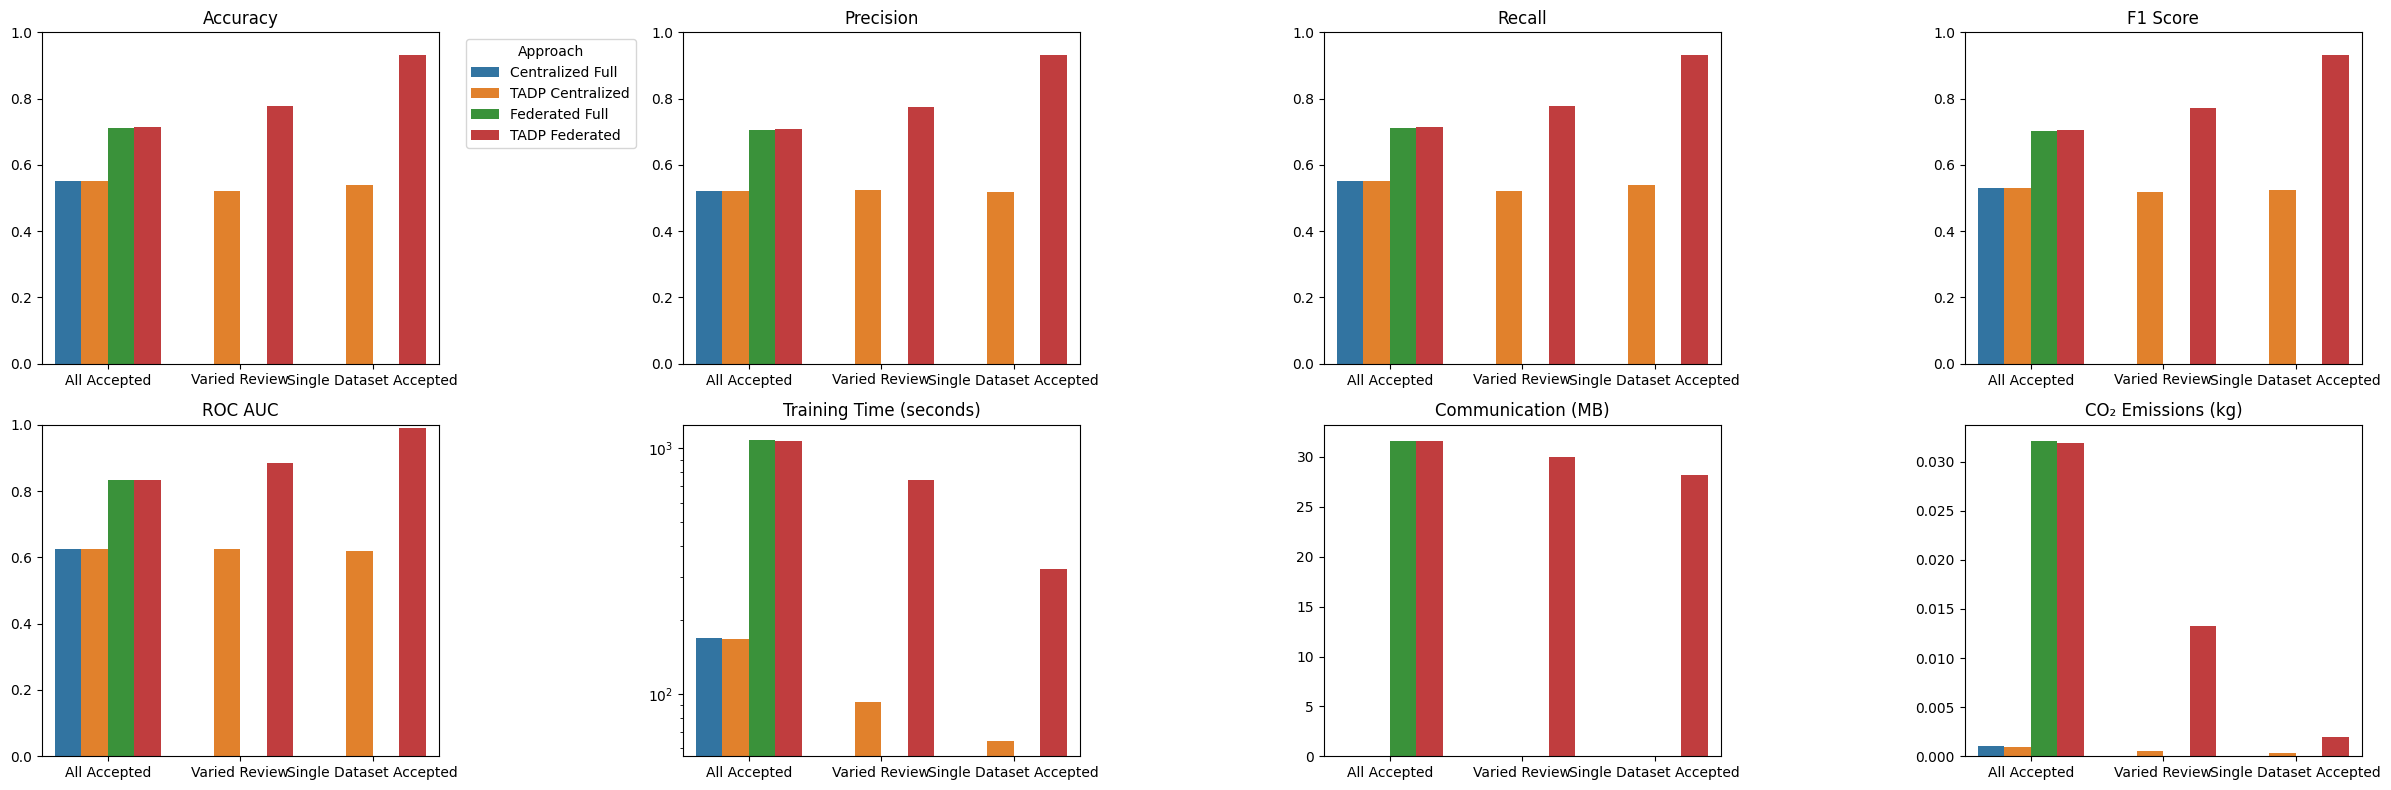

Ledgers updated with current results


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 8.1: Performance & Resource Tables with Styling
# ──────────────────────────────────────────────────────────────────────────────

# Define color maps (darker = higher values)
color_maps = {
    'performance': {
        'accuracy': 'Blues',
        'precision': 'Purples',
        'recall': 'Greens',
        'f1': 'Oranges',
        'roc_auc': 'Reds',
        'Time_s': 'YlOrBr_r'  # Reversed (darker = longer time)
    },
    'resources': {
        'Comm_MB': 'BuGn',
        'Energy_kWh': 'Greens',
        'Cost_USD': 'Reds',
        'CO2_kg': 'YlGn'
    }
}

# Table 1: Performance Metrics
perf_table = analysis_df[[
    'Scenario', 'Approach', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'Time_s'
]]

# Table 2: Resource/Cost Metrics
resource_table = analysis_df[[
    'Scenario', 'Approach', 'Comm_MB', 'Energy_kWh', 'Cost_USD', 'CO2_kg', 'Rounds'
]]

# Style and display performance table
perf_styled = perf_table.style \
    .background_gradient(cmap=color_maps['performance']['accuracy'], subset=['accuracy']) \
    .background_gradient(cmap=color_maps['performance']['precision'], subset=['precision']) \
    .background_gradient(cmap=color_maps['performance']['recall'], subset=['recall']) \
    .background_gradient(cmap=color_maps['performance']['f1'], subset=['f1']) \
    .background_gradient(cmap=color_maps['performance']['roc_auc'], subset=['roc_auc']) \
    .background_gradient(cmap=color_maps['performance']['Time_s'], subset=['Time_s']) \
    .format({
        'accuracy': '{:.2%}',
        'precision': '{:.2%}',
        'recall': '{:.2%}',
        'f1': '{:.2%}',
        'roc_auc': '{:.2%}',
        'Time_s': '{:.1f} s'
    }) \
    .set_caption('Table 1: Model Performance Metrics by Scenario')

display(perf_styled)

# Style and display resource table
resource_styled = resource_table.style \
    .background_gradient(cmap=color_maps['resources']['Comm_MB'], subset=['Comm_MB']) \
    .background_gradient(cmap=color_maps['resources']['Energy_kWh'], subset=['Energy_kWh']) \
    .background_gradient(cmap=color_maps['resources']['Cost_USD'], subset=['Cost_USD']) \
    .background_gradient(cmap=color_maps['resources']['CO2_kg'], subset=['CO2_kg']) \
    .format({
        'Comm_MB': '{:.1f} MB',
        'Energy_kWh': '{:.3f} kWh',
        'Cost_USD': '${:.3f}',
        'CO2_kg': '{:.3f} kg',
        'Rounds': '{:.0f}'
    }) \
    .set_caption('Table 2: Resource Usage and Costs by Scenario')

display(resource_styled)

# ──────────────────────────────────────────────────────────────────────────────
# Cell 8.2: Metric Visualizations
# ──────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# Define consistent colors for each approach
approach_colors = {
    'Centralized Full': '#1f77b4',
    'TADP Centralized': '#ff7f0e',
    'Federated Full': '#2ca02c',
    'TADP Federated': '#d62728'
}

# Metrics to visualize with their titles and scales
metrics_config = [
    {'col': 'accuracy', 'title': 'Accuracy', 'ylim': (0, 1), 'palette': 'Blues'},
    {'col': 'precision', 'title': 'Precision', 'ylim': (0, 1), 'palette': 'Purples'},
    {'col': 'recall', 'title': 'Recall', 'ylim': (0, 1), 'palette': 'Greens'},
    {'col': 'f1', 'title': 'F1 Score', 'ylim': (0, 1), 'palette': 'Oranges'},
    {'col': 'roc_auc', 'title': 'ROC AUC', 'ylim': (0, 1), 'palette': 'Reds'},
    {'col': 'Time_s', 'title': 'Training Time (seconds)', 'yscale': 'log', 'palette': 'YlOrBr_r'},
    {'col': 'Comm_MB', 'title': 'Communication (MB)', 'palette': 'BuGn'},
    {'col': 'CO2_kg', 'title': 'CO₂ Emissions (kg)', 'palette': 'YlGn'}
]

# Create figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(24, 8))
axes = axes.flatten()

for i, metric in enumerate(metrics_config):
    ax = axes[i]
    sns.barplot(
        data=analysis_df,
        x='Scenario',
        y=metric['col'],
        hue='Approach',
        palette=approach_colors,
        ax=ax
    )

    ax.set_title(metric['title'])
    ax.set_xlabel('')
    ax.set_ylabel('')

    if 'ylim' in metric:
        ax.set_ylim(metric['ylim'])
    if 'yscale' in metric:
        ax.set_yscale(metric['yscale'])

    if i == 0:  # Only show legend on first plot
        ax.legend(title='Approach', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.get_legend().remove()

plt.tight_layout()
plt.show()

# ──────────────────────────────────────────────────────────────────────────────
# Cell 8.3: Ledger Management
# ──────────────────────────────────────────────────────────────────────────────
def update_ledgers(results):
    """Append results to both central and local ledgers without overwriting"""
    central_ledger_path = "./ledgers/central/central_ledger.csv"
    central_data = []

    for scenario_name, res in results.items():
        scenario, approach = scenario_name
        gov_df = res.get('gov_df')

        if gov_df is not None:
            # Update central ledger
            for client, row in gov_df.iterrows():
                central_data.append({
                    'tx_id': uuid.uuid4().hex,
                    'timestamp': datetime.utcnow().isoformat(),
                    'client': client,
                    'version': version_counters.get(client, 1),
                    'record_count': len(client_data_splits[client]),
                    'dim1': row['dim1'],
                    'dim2': row['dim2'],
                    'dim3': row['dim3'],
                    'dim4': row['dim4'],
                    'dim5': row['dim5'],
                    'dim6': row['dim6'],
                    'pscore': row['pscore'],
                    'action': row['action']
                })

    # Append to central ledger
    if central_data:
        pd.DataFrame(central_data).to_csv(central_ledger_path, mode='a',
                                         header=not os.path.exists(central_ledger_path),
                                         index=False)

# Update ledgers with current results
update_ledgers(results)
print("Ledgers updated with current results")


Complete Ledger Data:


,client,version,timestamp,tx_id,record_count,dim1,dim2,dim3,dim4,dim5,dim6,pscore,initial_action,final_action
0,A,1,2025-05-28 20:41:56.297744,0dbadbcf86cc4e13b7e6da0cf5baf927,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
1,A,2,2025-05-28 20:44:48.487663,687e620709934d8babed4f19acb556f3,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
2,A,3,2025-05-28 20:47:43.253371,d37c94e0209047e19da85488a195ab20,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
3,A,4,2025-05-28 21:05:46.096290,bf4f8729ddbc4ee3afc08b06aeb2a5c4,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
4,A,5,2025-05-28 21:23:43.246652,01b7d5ef09074cadbb6cb963256aa6b5,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
5,A,6,2025-05-28 21:27:14.878354,ac671745c84046fe944c8feae1bc2806,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
6,A,7,2025-05-28 21:41:30.934453,4b4673a48211452cbdf271b51d3b135e,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
7,A,8,2025-05-28 21:48:53.179963,6514836858dc4b14b554a880dd7b5d71,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
8,B,1,2025-05-28 20:41:56.297744,5299639f8c214d8dbdac55047a9c2690,11133,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
9,B,2,2025-05-28 20:44:48.487663,b84c08cfc6d04e0682787092b2ffafc4,11133,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT


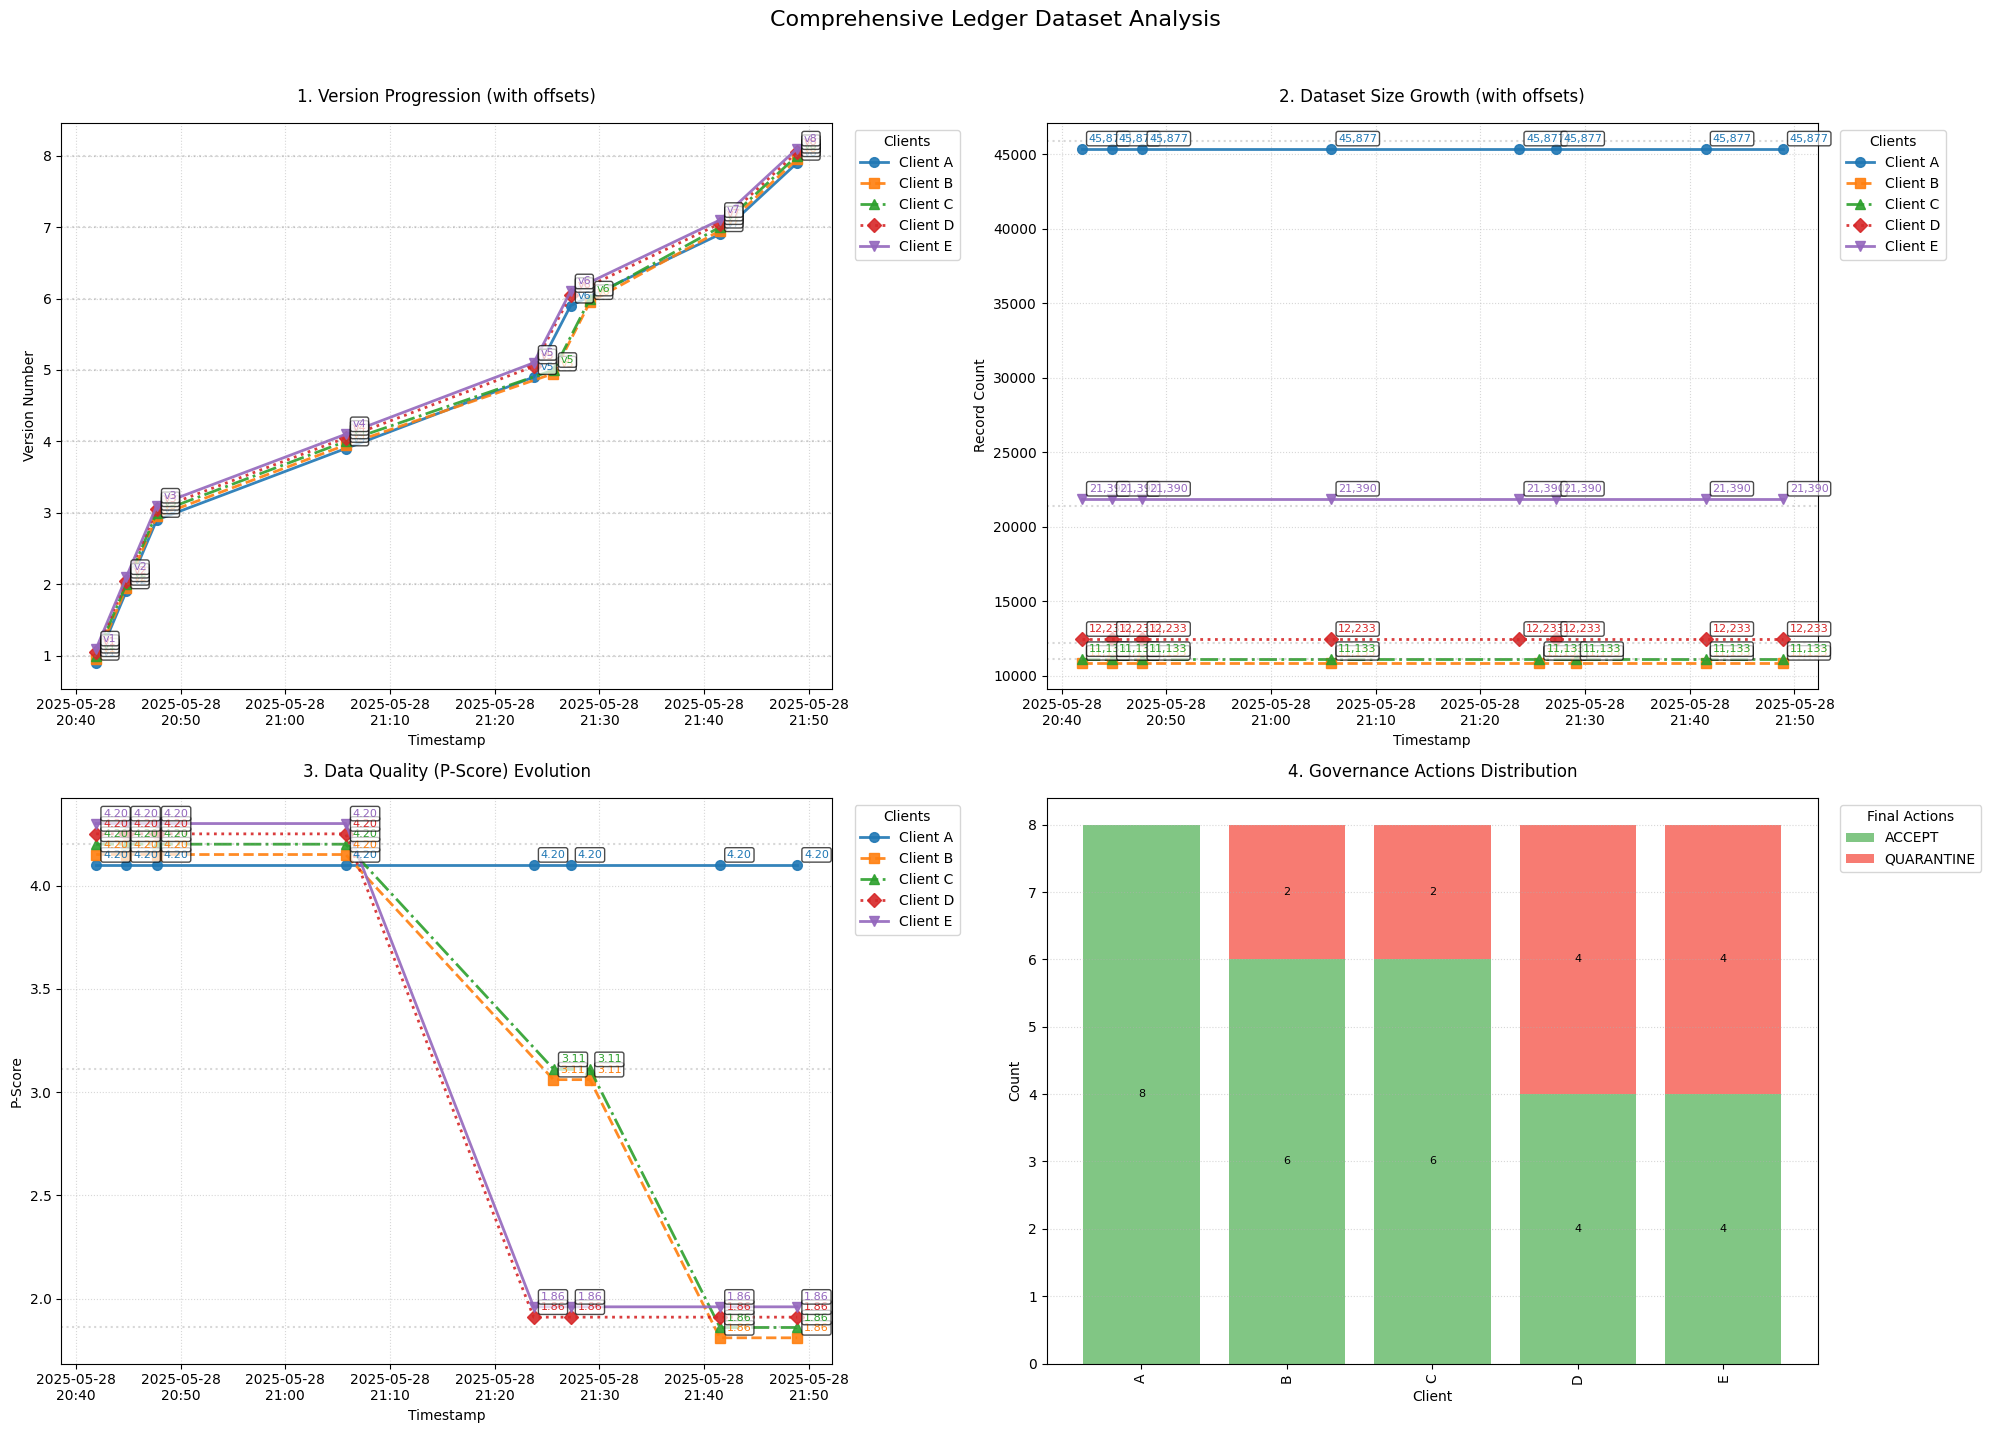

In [ ]:
#──────────────────────────────────────────────────────────────────────────────
# 9.1 Ledgers + Versions over time + Excellent visualizations (Corrected)
#──────────────────────────────────────────────────────────────────────────────

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# 1. Read and merge all ledgers (local and central)
all_data = []
for path in sorted(glob.glob("./ledgers/local/*.csv")):
    df = pd.read_csv(path, parse_dates=["timestamp"])
    df['source'] = 'local'
    all_data.append(df)
try:
    central_df = pd.read_csv("./ledgers/central/central_ledger.csv", parse_dates=["timestamp"])
    central_df['source'] = 'central'
    all_data.append(central_df)
except FileNotFoundError:
    pass

if not all_data:
    print("No ledger files found!")
else:
    # Merge and sort all ledger data
    combined = pd.concat(all_data, ignore_index=True)
    combined = combined.sort_values(['client', 'version', 'timestamp'])

    # Build summary per (client, version)
    group_cols = ['client', 'version']
    result_rows = []
    for (client, version), g in combined.groupby(group_cols):
        # Initial and final actions
        initial_idx = g['timestamp'].idxmin()
        initial_action = g.loc[initial_idx]['action']
        final_idx = g['timestamp'].idxmax()
        final_action = g.loc[final_idx]['action']
        final_row = g.loc[final_idx]

        # Most recent value for features
        def last_non_nan(series):
            return series.dropna().iloc[-1] if not series.dropna().empty else np.nan

        result_rows.append({
            "client": client,
            "version": version,
            "timestamp": final_row['timestamp'],
            "tx_id": final_row.get('tx_id', None),
            "record_count": last_non_nan(g['record_count']),
            "dim1": last_non_nan(g['dim1']),
            "dim2": last_non_nan(g['dim2']),
            "dim3": last_non_nan(g['dim3']),
            "dim4": last_non_nan(g['dim4']),
            "dim5": last_non_nan(g['dim5']),
            "dim6": last_non_nan(g['dim6']),
            "pscore": last_non_nan(g['pscore']),
            "initial_action": initial_action,
            "final_action": final_action,
        })

    summary_df = pd.DataFrame(result_rows)
    summary_df = summary_df.sort_values(['client', 'version'])

    # Display summary table
    print("\nComplete Ledger Data:")
    display(summary_df)

    # (OPTIONAL) Filter: If you want only the 7 main scenarios in scenario-level plots
    # If you want to filter by scenario in scenario tables, do that on analysis_df, NOT here

    # === Ledger Visualizations (per client, version, and actions) ===
    clients = sorted(summary_df['client'].unique())
    line_styles = ['-', '--', '-.', ':'] * 2
    markers = ['o', 's', '^', 'D', 'v', 'p', '*']
    colors = plt.cm.tab10.colors[:len(clients)]

    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle('Comprehensive Ledger Dataset Analysis', y=1.02, fontsize=16)

    # 1. Version Progression
    ax1 = axes[0, 0]
    version_offsets = np.linspace(-0.1, 0.1, len(clients))
    for i, (client, color) in enumerate(zip(clients, colors)):
        client_data = summary_df[summary_df['client'] == client]
        adjusted_versions = client_data['version'] + version_offsets[i]
        ax1.plot(
            client_data['timestamp'],
            adjusted_versions,
            marker=markers[i % len(markers)],
            linestyle=line_styles[i % len(line_styles)],
            markersize=7,
            linewidth=2,
            color=color,
            alpha=0.9,
            label=f'Client {client}'
        )
        for _, row in client_data.iterrows():
            ax1.annotate(
                f"v{row['version']}",
                (row['timestamp'], row['version'] + version_offsets[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8, color=color,
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7)
            )
    ax1.set_title('1. Version Progression (with offsets)', pad=15)
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Version Number')
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    ax1.grid(True, linestyle=':', alpha=0.5)
    ax1.legend(title='Clients', bbox_to_anchor=(1.02, 1), loc='upper left')
    for version in summary_df['version'].unique():
        ax1.axhline(y=version, color='gray', linestyle=':', alpha=0.3)

    # 2. Dataset Size Growth
    ax2 = axes[0, 1]
    count_offsets = np.linspace(-500, 500, len(clients))
    for i, (client, color) in enumerate(zip(clients, colors)):
        client_data = summary_df[summary_df['client'] == client]
        adjusted_counts = client_data['record_count'] + count_offsets[i]
        ax2.plot(
            client_data['timestamp'],
            adjusted_counts,
            marker=markers[i % len(markers)],
            linestyle=line_styles[i % len(line_styles)],
            markersize=7,
            linewidth=2,
            color=color,
            alpha=0.9,
            label=f'Client {client}'
        )
        for _, row in client_data.iterrows():
            ax2.annotate(
                f"{int(row['record_count']):,}" if not pd.isna(row['record_count']) else '',
                (row['timestamp'], row['record_count'] + count_offsets[i] if not pd.isna(row['record_count']) else 0),
                xytext=(5, 5), textcoords='offset points', fontsize=8, color=color,
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7)
            )
    ax2.set_title('2. Dataset Size Growth (with offsets)', pad=15)
    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Record Count')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    ax2.grid(True, linestyle=':', alpha=0.5)
    ax2.legend(title='Clients', bbox_to_anchor=(1.02, 1), loc='upper left')
    for count in summary_df['record_count'].unique():
        ax2.axhline(y=count, color='gray', linestyle=':', alpha=0.3)

    # 3. P-Score Evolution
    ax3 = axes[1, 0]
    if 'pscore' in summary_df.columns:
        score_offsets = np.linspace(-0.1, 0.1, len(clients))
        for i, (client, color) in enumerate(zip(clients, colors)):
            client_data = summary_df[summary_df['client'] == client]
            adjusted_scores = client_data['pscore'] + score_offsets[i]
            ax3.plot(
                client_data['timestamp'],
                adjusted_scores,
                marker=markers[i % len(markers)],
                linestyle=line_styles[i % len(line_styles)],
                markersize=7,
                linewidth=2,
                color=color,
                alpha=0.9,
                label=f'Client {client}'
            )
            for _, row in client_data.iterrows():
                ax3.annotate(
                    f"{row['pscore']:.2f}" if not pd.isna(row['pscore']) else '',
                    (row['timestamp'], row['pscore'] + score_offsets[i] if not pd.isna(row['pscore']) else 0),
                    xytext=(5, 5), textcoords='offset points', fontsize=8, color=color,
                    bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7)
                )
        ax3.set_title('3. Data Quality (P-Score) Evolution', pad=15)
        ax3.set_xlabel('Timestamp')
        ax3.set_ylabel('P-Score')
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
        ax3.grid(True, linestyle=':', alpha=0.5)
        ax3.legend(title='Clients', bbox_to_anchor=(1.02, 1), loc='upper left')
        for score in summary_df['pscore'].unique():
            ax3.axhline(y=score, color='gray', linestyle=':', alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'P-Score data not available', ha='center', va='center', fontsize=12)
        ax3.set_title('3. Data Quality Metrics', pad=15)

    # 4. Action Distribution
    ax4 = axes[1, 1]
    if 'final_action' in summary_df.columns:
        action_counts = summary_df.groupby(['client', 'final_action']).size().unstack(fill_value=0)
        action_colors = {
            'ACCEPT': '#4CAF50',      # Green
            'REVIEW': '#FFC107',      # Yellow
            'QUARANTINE': '#F44336'   # Red
        }
        # Only plot actions that exist
        actions_to_plot = [a for a in action_colors if a in action_counts.columns]
        action_counts[actions_to_plot].plot(
            kind='bar', stacked=True, ax=ax4,
            color=[action_colors[a] for a in actions_to_plot], alpha=0.7, width=0.8
        )
        for p in ax4.patches:
            if p.get_height() > 0:
                ax4.annotate(
                    int(p.get_height()),
                    (p.get_x() + p.get_width()/2., p.get_y() + p.get_height()/2),
                    ha='center', va='center', color='black', fontsize=8
                )
        ax4.set_title('4. Governance Actions Distribution', pad=15)
        ax4.set_xlabel('Client')
        ax4.set_ylabel('Count')
        ax4.legend(title='Final Actions', bbox_to_anchor=(1.02, 1))
        ax4.grid(True, linestyle=':', alpha=0.5, axis='y')
    else:
        ax4.text(0.5, 0.5, 'Action data not available', ha='center', va='center', fontsize=12)
        ax4.set_title('4. Governance Actions', pad=15)

    plt.tight_layout()
    plt.show()



Complete Ledger Data:


,client,version,timestamp,tx_id,record_count,dim1,dim2,dim3,dim4,dim5,dim6,pscore,initial_action,final_action
0,A,1,2025-05-28 20:41:56.297744,0dbadbcf86cc4e13b7e6da0cf5baf927,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
1,A,2,2025-05-28 20:44:48.487663,687e620709934d8babed4f19acb556f3,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
2,A,3,2025-05-28 20:47:43.253371,d37c94e0209047e19da85488a195ab20,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
3,A,4,2025-05-28 21:05:46.096290,bf4f8729ddbc4ee3afc08b06aeb2a5c4,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
4,A,5,2025-05-28 21:23:43.246652,01b7d5ef09074cadbb6cb963256aa6b5,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
5,A,6,2025-05-28 21:27:14.878354,ac671745c84046fe944c8feae1bc2806,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
6,A,7,2025-05-28 21:41:30.934453,4b4673a48211452cbdf271b51d3b135e,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
7,A,8,2025-05-28 21:48:53.179963,6514836858dc4b14b554a880dd7b5d71,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
8,B,1,2025-05-28 20:41:56.297744,5299639f8c214d8dbdac55047a9c2690,11133,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
9,B,2,2025-05-28 20:44:48.487663,b84c08cfc6d04e0682787092b2ffafc4,11133,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT


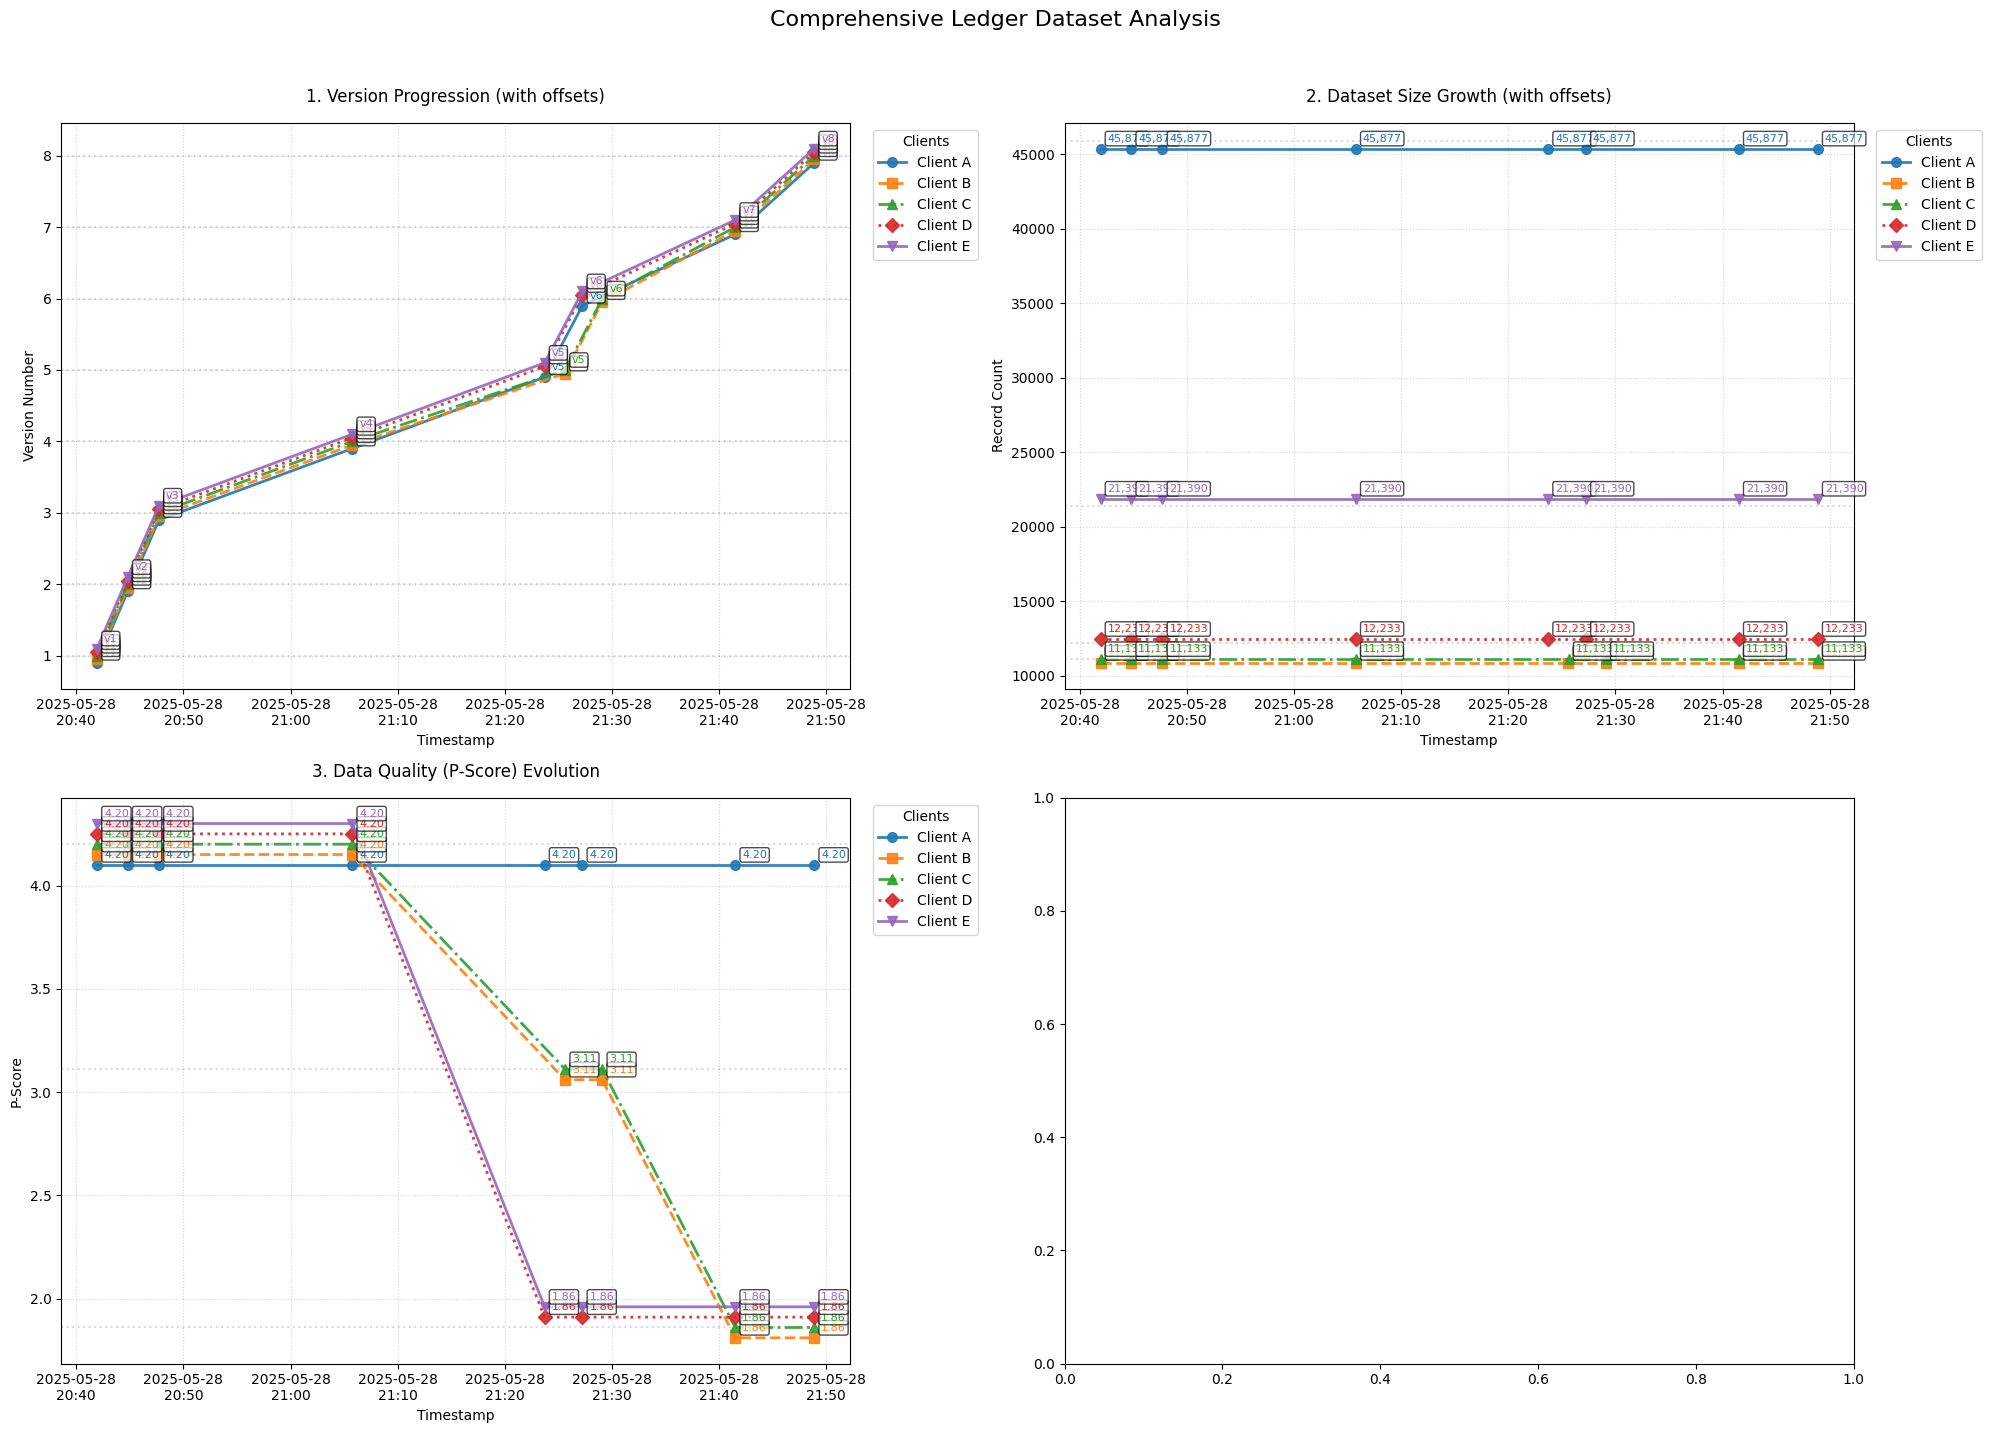


Initial Actions by Client:


initial_action,ACCEPT,QUARANTINE,REVIEW
client,,,
A,8,0,0
B,4,2,2
C,4,2,2
D,4,4,0
E,4,4,0


Final Actions by Client:


final_action,ACCEPT,QUARANTINE
client,,
A,8,0
B,6,2
C,6,2
D,4,4
E,4,4


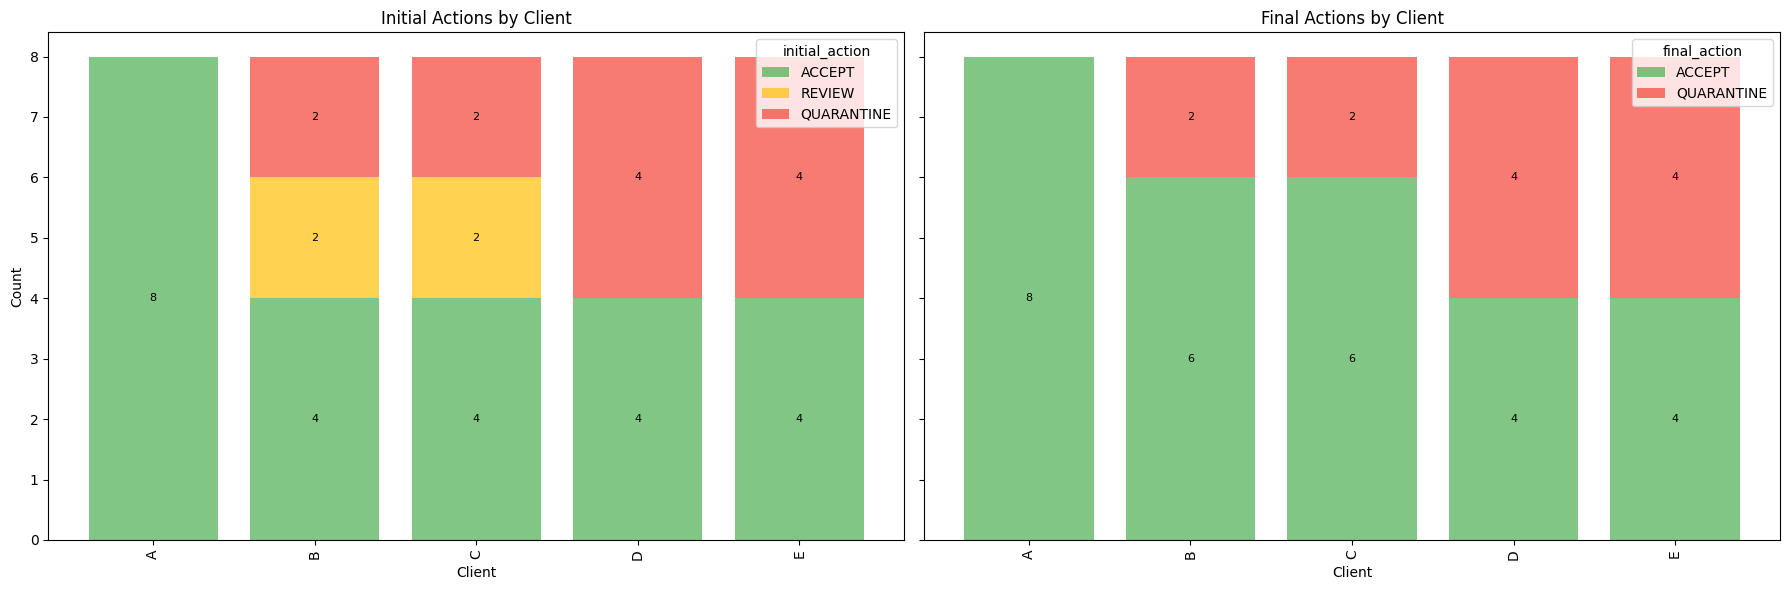

In [ ]:
#──────────────────────────────────────────────────────────────────────────────
# 9.1 Ledgers + Versions over time + Excellent visualizations (Corrected)
#──────────────────────────────────────────────────────────────────────────────

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# 1. Read and merge all ledgers (local and central)
all_data = []
for path in sorted(glob.glob("./ledgers/local/*.csv")):
    df = pd.read_csv(path, parse_dates=["timestamp"])
    df['source'] = 'local'
    all_data.append(df)
try:
    central_df = pd.read_csv(
        "./ledgers/central/central_ledger.csv",
        parse_dates=["timestamp"]
    )
    central_df['source'] = 'central'
    all_data.append(central_df)
except FileNotFoundError:
    pass

if not all_data:
    print("No ledger files found!")
else:
    # Merge and sort all ledger data
    combined = pd.concat(all_data, ignore_index=True)
    combined = combined.sort_values(['client', 'version', 'timestamp'])

    # Build summary per (client, version)
    result_rows = []
    def last_non_nan(series):
        return series.dropna().iloc[-1] if not series.dropna().empty else np.nan

    for (client, version), g in combined.groupby(['client', 'version']):
        initial_idx = g['timestamp'].idxmin()
        final_idx   = g['timestamp'].idxmax()
        initial_action = g.loc[initial_idx, 'action']
        final_action   = g.loc[final_idx,   'action']
        final_row      = g.loc[final_idx]

        result_rows.append({
            "client":        client,
            "version":       version,
            "timestamp":     final_row['timestamp'],
            "tx_id":         final_row.get('tx_id', None),
            "record_count":  last_non_nan(g['record_count']),
            "dim1":          last_non_nan(g['dim1']),
            "dim2":          last_non_nan(g['dim2']),
            "dim3":          last_non_nan(g['dim3']),
            "dim4":          last_non_nan(g['dim4']),
            "dim5":          last_non_nan(g['dim5']),
            "dim6":          last_non_nan(g['dim6']),
            "pscore":        last_non_nan(g['pscore']),
            "initial_action": initial_action,
            "final_action":   final_action,
        })

    summary_df = pd.DataFrame(result_rows).sort_values(['client','version'])

    # Display summary table
    print("\nComplete Ledger Data:")
    display(summary_df)

    # === Ledger Visualizations (per client, version, and actions) ===
    clients     = sorted(summary_df['client'].unique())
    line_styles = ['-', '--', '-.', ':'] * 2
    markers     = ['o', 's', '^', 'D', 'v', 'p', '*']
    colors      = plt.cm.tab10.colors[:len(clients)]

    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle('Comprehensive Ledger Dataset Analysis', y=1.02, fontsize=16)

    # 1. Version Progression
    ax1 = axes[0, 0]
    version_offsets = np.linspace(-0.1, 0.1, len(clients))
    for i, (client, color) in enumerate(zip(clients, colors)):
        cd = summary_df[summary_df['client'] == client]
        av = cd['version'] + version_offsets[i]
        ax1.plot(
            cd['timestamp'], av,
            marker=markers[i % len(markers)],
            linestyle=line_styles[i % len(line_styles)],
            markersize=7, linewidth=2, color=color, alpha=0.9,
            label=f'Client {client}'
        )
        for _, row in cd.iterrows():
            ax1.annotate(
                f"v{int(row['version'])}",
                (row['timestamp'], row['version'] + version_offsets[i]),
                xytext=(5,5), textcoords='offset points', fontsize=8, color=color,
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7)
            )
    ax1.set_title('1. Version Progression (with offsets)', pad=15)
    ax1.set_xlabel('Timestamp'); ax1.set_ylabel('Version Number')
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    ax1.grid(True, linestyle=':', alpha=0.5)
    ax1.legend(title='Clients', bbox_to_anchor=(1.02,1), loc='upper left')
    for v in summary_df['version'].unique():
        ax1.axhline(v, color='gray', linestyle=':', alpha=0.3)

    # 2. Dataset Size Growth
    ax2 = axes[0, 1]
    count_offsets = np.linspace(-500, 500, len(clients))
    for i, (client, color) in enumerate(zip(clients, colors)):
        cd = summary_df[summary_df['client'] == client]
        ac = cd['record_count'] + count_offsets[i]
        ax2.plot(
            cd['timestamp'], ac,
            marker=markers[i % len(markers)],
            linestyle=line_styles[i % len(line_styles)],
            markersize=7, linewidth=2, color=color, alpha=0.9,
            label=f'Client {client}'
        )
        for _, row in cd.iterrows():
            ax2.annotate(
                f"{int(row['record_count']):,}",
                (row['timestamp'], row['record_count'] + count_offsets[i]),
                xytext=(5,5), textcoords='offset points', fontsize=8, color=color,
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7)
            )
    ax2.set_title('2. Dataset Size Growth (with offsets)', pad=15)
    ax2.set_xlabel('Timestamp'); ax2.set_ylabel('Record Count')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    ax2.grid(True, linestyle=':', alpha=0.5)
    ax2.legend(title='Clients', bbox_to_anchor=(1.02,1), loc='upper left')
    for rc in summary_df['record_count'].unique():
        ax2.axhline(rc, color='gray', linestyle=':', alpha=0.3)

    # 3. P-Score Evolution
    ax3 = axes[1, 0]
    if 'pscore' in summary_df:
        score_offsets = np.linspace(-0.1,0.1,len(clients))
        for i, (client, color) in enumerate(zip(clients, colors)):
            cd = summary_df[summary_df['client'] == client]
            as_ = cd['pscore'] + score_offsets[i]
            ax3.plot(
                cd['timestamp'], as_,
                marker=markers[i % len(markers)],
                linestyle=line_styles[i % len(line_styles)],
                markersize=7, linewidth=2, color=color, alpha=0.9,
                label=f'Client {client}'
            )
            for _, row in cd.iterrows():
                ax3.annotate(
                    f"{row['pscore']:.2f}",
                    (row['timestamp'], row['pscore'] + score_offsets[i]),
                    xytext=(5,5), textcoords='offset points', fontsize=8, color=color,
                    bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7)
                )
        ax3.set_title('3. Data Quality (P-Score) Evolution', pad=15)
        ax3.set_xlabel('Timestamp'); ax3.set_ylabel('P-Score')
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
        ax3.grid(True, linestyle=':', alpha=0.5)
        ax3.legend(title='Clients', bbox_to_anchor=(1.02,1), loc='upper left')
        for ps in summary_df['pscore'].unique():
            ax3.axhline(ps, color='gray', linestyle=':', alpha=0.3)
    else:
        ax3.text(0.5,0.5,'P-Score data not available', ha='center', va='center', fontsize=12)
        ax3.set_title('3. Data Quality Metrics', pad=15)

    plt.tight_layout()
    plt.show()


    # ──────────────────────────────────────────────────────────────────────────
    # 4. Ready-to-use Correction: show Initial vs Final actions per client
    #──────────────────────────────────────────────────────────────────────────

    # Count initial and final actions
    initial_counts = (
        summary_df
        .groupby(['client','initial_action'])
        .size()
        .unstack(fill_value=0)
    )
    final_counts = (
        summary_df
        .groupby(['client','final_action'])
        .size()
        .unstack(fill_value=0)
    )

    print("\nInitial Actions by Client:")
    display(initial_counts)

    print("Final Actions by Client:")
    display(final_counts)

    # Plot side-by-side bar charts
    fig2, axes2 = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
    action_colors = {
        'ACCEPT':      '#4CAF50',
        'REVIEW':      '#FFC107',
        'QUARANTINE':  '#F44336'
    }

    # Initial
    cols_init = [c for c in action_colors if c in initial_counts.columns]
    initial_counts[cols_init].plot(
        kind='bar', stacked=True, ax=axes2[0],
        color=[action_colors[c] for c in cols_init],
        alpha=0.7, width=0.8
    )
    axes2[0].set_title('Initial Actions by Client')
    axes2[0].set_xlabel('Client'); axes2[0].set_ylabel('Count')
    for p in axes2[0].patches:
        if p.get_height() > 0:
            axes2[0].annotate(
                int(p.get_height()),
                (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2),
                ha='center', va='center', fontsize=8
            )

    # Final
    cols_fin = [c for c in action_colors if c in final_counts.columns]
    final_counts[cols_fin].plot(
        kind='bar', stacked=True, ax=axes2[1],
        color=[action_colors[c] for c in cols_fin],
        alpha=0.7, width=0.8
    )
    axes2[1].set_title('Final Actions by Client')
    axes2[1].set_xlabel('Client')
    for p in axes2[1].patches:
        if p.get_height() > 0:
            axes2[1].annotate(
                int(p.get_height()),
                (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2),
                ha='center', va='center', fontsize=8
            )

    plt.tight_layout()
    plt.show()


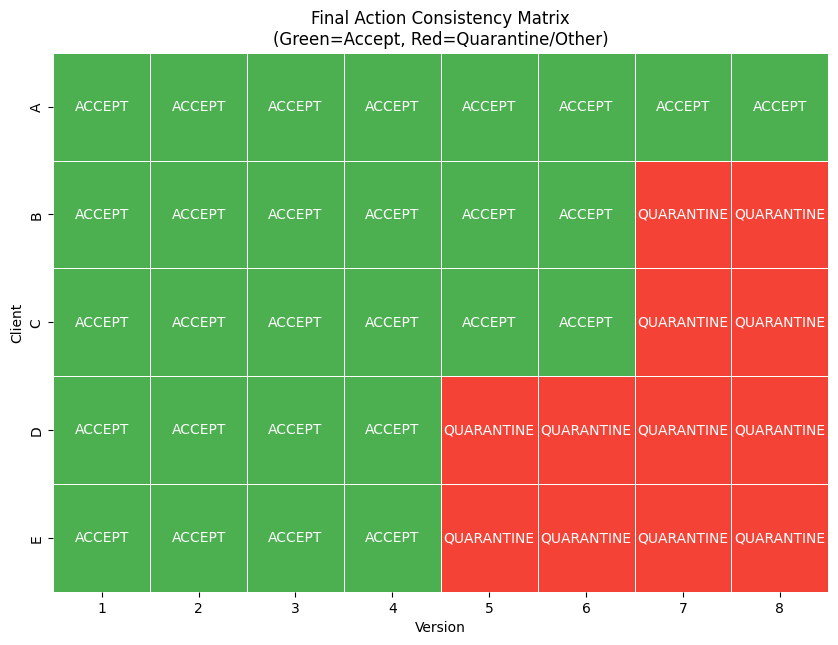

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_decision_consistency(combined):
    # For each client/version: extract the full final action for that version
    consistency = (combined
                   .sort_values('timestamp')
                   .groupby(['client', 'version'])
                   .tail(1)
                   .reset_index(drop=True))
    # Pivot to matrix
    mat = consistency.pivot(index='client', columns='version', values='action')
    plt.figure(figsize=(mat.shape[1] + 2, mat.shape[0] + 2))
    ax = sns.heatmap(mat.isin(['ACCEPT']), cmap=['#F44336', '#4CAF50'], cbar=False, linewidths=0.5,
                     annot=mat, fmt='', annot_kws={"size": 10})
    ax.set_title("Final Action Consistency Matrix\n(Green=Accept, Red=Quarantine/Other)")
    plt.ylabel('Client')
    plt.xlabel('Version')
    plt.show()

plot_decision_consistency(combined)

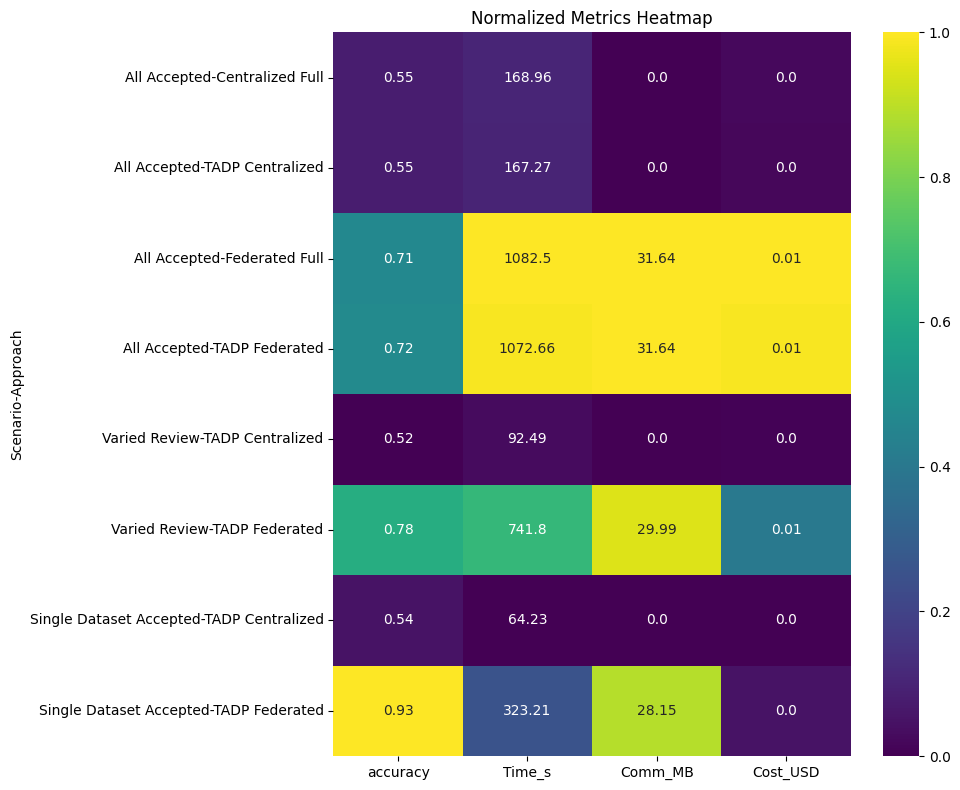

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choose the correct columns for analysis
hm = analysis_df.set_index(['Scenario', 'Approach'])[
    ['accuracy', 'Time_s', 'Comm_MB', 'Cost_USD']
]
hm_norm = (hm - hm.min()) / (hm.max() - hm.min())

plt.figure(figsize=(10, 8))
sns.heatmap(hm_norm, annot=hm.round(2), fmt="", cmap="viridis")
plt.title("Normalized Metrics Heatmap")
plt.tight_layout()
plt.show()


<ipython-input-13-f8ee2fac7bad>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(analysis_df["Scenario_Approach_Num"].unique(), rotation=0, fontsize=9)
<ipython-input-13-f8ee2fac7bad>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(analysis_df["Scenario_Approach_Num"].unique(), rotation=0, fontsize=9)
<ipython-input-13-f8ee2fac7bad>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(analysis_df["Scenario_Approach_Num"].unique(), rotation=0, fontsize=9)
<ipython-input-13-f8ee2fac7bad>:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(analysis_df["Scenario_Appro

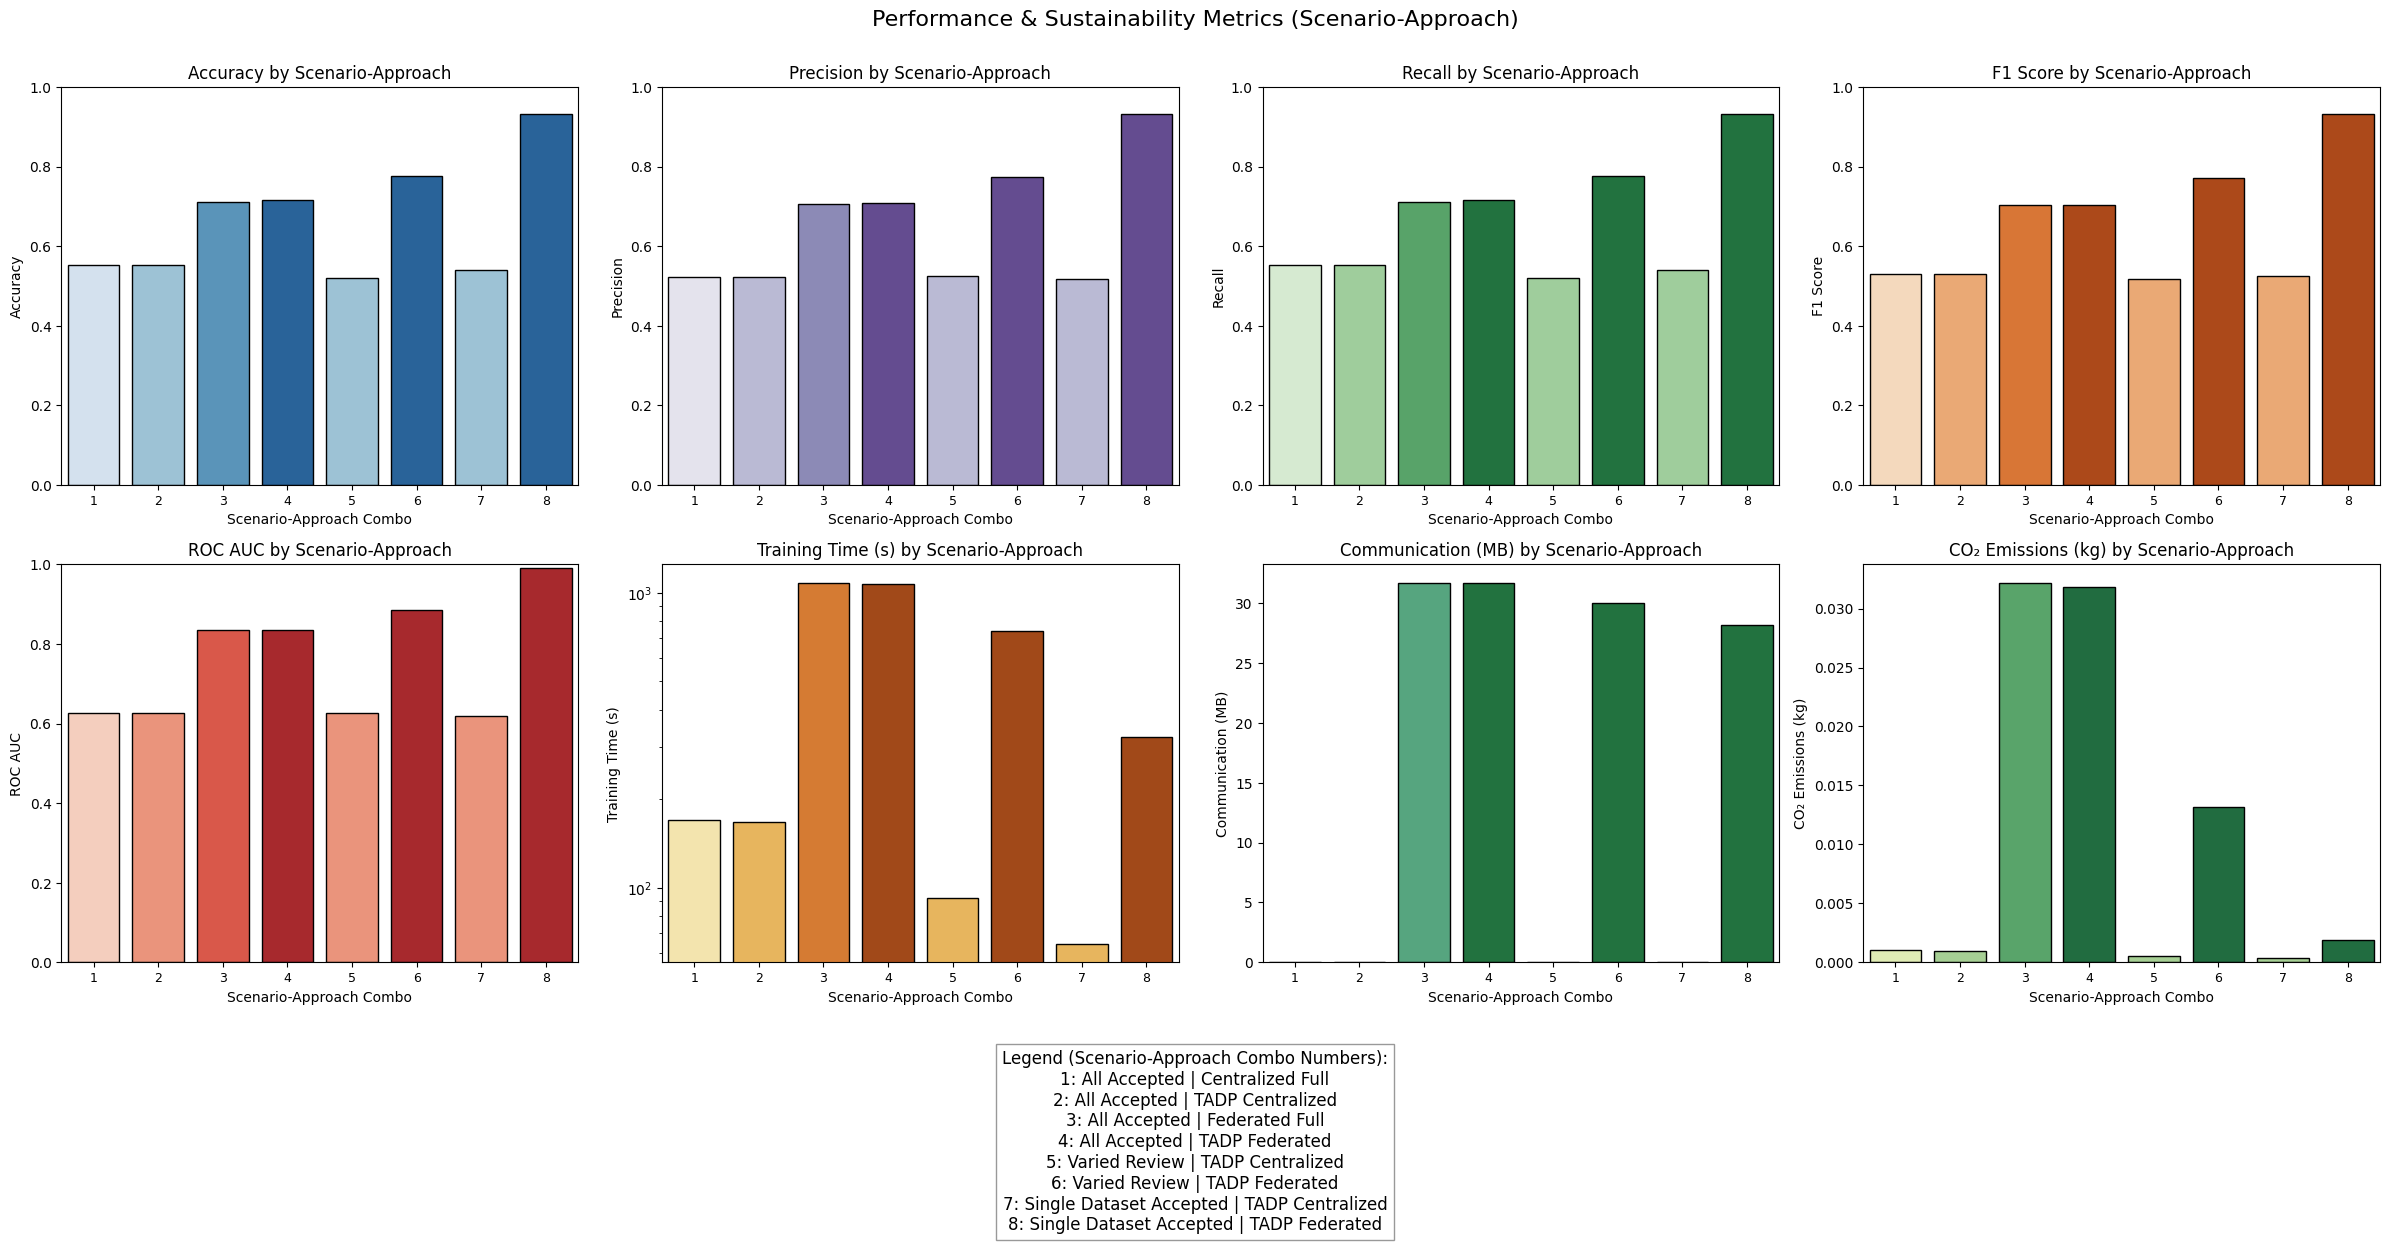

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Your data setup
metric_list = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'Time_s', 'Comm_MB', 'CO2_kg']
metric_titles = {
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'f1': 'F1 Score',
    'roc_auc': 'ROC AUC',
    'Time_s': 'Training Time (s)',
    'Comm_MB': 'Communication (MB)',
    'CO2_kg': 'CO₂ Emissions (kg)'
}
metrics_palettes = {
    'accuracy': 'Blues',
    'precision': 'Purples',
    'recall': 'Greens',
    'f1': 'Oranges',
    'roc_auc': 'Reds',
    'Time_s': 'YlOrBr',
    'Comm_MB': 'BuGn',
    'CO2_kg': 'YlGn'
}

# 1. Numeric label for each scenario-approach
analysis_df = analysis_df.copy()
analysis_df["Scenario_Approach"] = (
    analysis_df["Scenario"].astype(str) + " | " + analysis_df["Approach"].astype(str)
)
combo_labels = analysis_df["Scenario_Approach"].unique()
combo_map = {v: str(i + 1) for i, v in enumerate(combo_labels)}
analysis_df["Scenario_Approach_Num"] = analysis_df["Scenario_Approach"].map(combo_map)

# 2. Plot setup
rows, cols = 2, 4
fig, axes = plt.subplots(rows, cols, figsize=(24, 10))
axes = axes.flatten()

for i, metric in enumerate(metric_list):
    if metric in analysis_df.columns:
        # Pick correct palette for each metric, mapping unique values to shades
        palette = sns.color_palette(metrics_palettes.get(metric, "Blues"),
                                   n_colors=analysis_df["Approach"].nunique())
        approach_order = analysis_df["Approach"].unique().tolist()
        palette_dict = {a: palette[j] for j, a in enumerate(approach_order)}
        sns.barplot(
            ax=axes[i],
            data=analysis_df,
            x="Scenario_Approach_Num",
            y=metric,
            hue="Approach",
            hue_order=approach_order,
            palette=palette_dict,
            dodge=False,
            edgecolor="black"
        )
        axes[i].set_title(f'{metric_titles[metric]} by Scenario-Approach', fontsize=12)
        axes[i].set_xlabel('Scenario-Approach Combo')
        axes[i].set_ylabel(metric_titles[metric])
        axes[i].set_xticklabels(analysis_df["Scenario_Approach_Num"].unique(), rotation=0, fontsize=9)
        if metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            axes[i].set_ylim(0, 1)
        if metric == 'Time_s':
            axes[i].set_yscale('log')
        # Remove per-subplot legends!
        axes[i].get_legend().remove()
    else:
        axes[i].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.97])
fig.suptitle("Performance & Sustainability Metrics (Scenario-Approach)", fontsize=16, y=1.01)

# 3. Add mapping legend for scenario-approach numbers
legend_text = "\n".join([f"{num}: {combo}" for combo, num in combo_map.items()])
plt.figtext(
    0.5, -0.03,
    "Legend (Scenario-Approach Combo Numbers):\n" + legend_text,
    ha='center', fontsize=12, va="top", wrap=True,
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8)
)

plt.show()


In [ ]:
# ─────────────────────────────────────────────
# Cell 7.11: Professional Local Ledger Display (Q1 Level)
# ─────────────────────────────────────────────
import pandas as pd
import glob
from IPython.display import display

def color_action_cell(val):
    if isinstance(val, str):
        if 'ACCEPT' in val:
            return 'background-color: #d4edda; color: #155724; font-weight:bold'
        elif 'REVIEW' in val:
            return 'background-color: #fff3cd; color: #856404; font-weight:bold'
        elif 'QUARANTINE' in val:
            return 'background-color: #f8d7da; color: #721c24; font-weight:bold'
    return ''

print("\n======= LOCAL LEDGER: VERSION ACTION TRAJECTORY (per Client) =======\n")

local_ledgers = sorted(glob.glob('./ledgers/local/*_ledger.csv'))
if not local_ledgers:
    print("No local ledgers found.")
else:
    for ledger_file in local_ledgers:
        client_id = os.path.basename(ledger_file).split('_')[0]
        df = pd.read_csv(ledger_file)
        if df.empty:
            print(f"\n--- Ledger for Client {client_id} is empty ---")
            continue
        df = df.sort_values(['version', 'timestamp'])
        # Group by version, then aggregate action trajectory
        agg_df = df.groupby('version').agg({
            'timestamp': 'first',
            'tx_id': 'first',
            'record_count': 'first',
            'pscore': 'first',
            'action': lambda x: ' → '.join(x)
        }).reset_index()
        agg_df.insert(0, 'client', client_id)
        # Only keep relevant columns for publication
        display(
            agg_df.style.applymap(color_action_cell, subset=['action'])
                .format({'pscore': '{:.2f}'})
                .set_caption(f"Client {client_id}: Action trajectory per version (duplicates removed, shows review/override chain).")
        )




======= LOCAL LEDGER: VERSION ACTION TRAJECTORY (per Client) =======



<ipython-input-14-0043bd157308>:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  agg_df.style.applymap(color_action_cell, subset=['action'])


,client,version,timestamp,tx_id,record_count,pscore,action
0,A,1,2025-05-28T20:41:56.297744,0dbadbcf86cc4e13b7e6da0cf5baf927,45877,4.20,ACCEPT
1,A,2,2025-05-28T20:44:48.487663,687e620709934d8babed4f19acb556f3,45877,4.20,ACCEPT
2,A,3,2025-05-28T20:47:43.253371,d37c94e0209047e19da85488a195ab20,45877,4.20,ACCEPT
3,A,4,2025-05-28T21:05:46.096290,bf4f8729ddbc4ee3afc08b06aeb2a5c4,45877,4.20,ACCEPT
4,A,5,2025-05-28T21:23:43.246652,01b7d5ef09074cadbb6cb963256aa6b5,45877,4.20,ACCEPT
5,A,6,2025-05-28T21:27:14.878354,ac671745c84046fe944c8feae1bc2806,45877,4.20,ACCEPT
6,A,7,2025-05-28T21:41:30.934453,4b4673a48211452cbdf271b51d3b135e,45877,4.20,ACCEPT
7,A,8,2025-05-28T21:42:38.759301,55eb6fe77cf44f0186002ec089277051,45877,4.20,ACCEPT


<ipython-input-14-0043bd157308>:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  agg_df.style.applymap(color_action_cell, subset=['action'])


,client,version,timestamp,tx_id,record_count,pscore,action
0,B,1,2025-05-28T20:41:56.297744,5299639f8c214d8dbdac55047a9c2690,11133,4.20,ACCEPT
1,B,2,2025-05-28T20:44:48.487663,b84c08cfc6d04e0682787092b2ffafc4,11133,4.20,ACCEPT
2,B,3,2025-05-28T20:47:43.253371,aec1d0b8cad244aaa9b9d6bf597df368,11133,4.20,ACCEPT
3,B,4,2025-05-28T21:05:46.096290,a63f41f0ff2e4630b5f4a314ccc2f149,11133,4.20,ACCEPT
4,B,5,2025-05-28T21:23:43.246652,83c6e0fd0f0243df9ca6a675d211099c,11133,3.11,REVIEW → ACCEPT
5,B,6,2025-05-28T21:27:14.878354,16701337ebcf447e8c6bfb9c3d12849f,11133,3.11,REVIEW → ACCEPT
6,B,7,2025-05-28T21:41:30.934453,4c5d5042885340be9d1d4a0f4e317887,11133,1.86,QUARANTINE
7,B,8,2025-05-28T21:42:38.759301,9f7c161d94d04913b5a778006a93d6ec,11133,1.86,QUARANTINE


<ipython-input-14-0043bd157308>:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  agg_df.style.applymap(color_action_cell, subset=['action'])


,client,version,timestamp,tx_id,record_count,pscore,action
0,C,1,2025-05-28T20:41:56.297744,75fe892e64f642e59740952805b436de,11133,4.20,ACCEPT
1,C,2,2025-05-28T20:44:48.487663,6ac5c2caed9b4a47aacbd74b203f39eb,11133,4.20,ACCEPT
2,C,3,2025-05-28T20:47:43.253371,84adab1af9f246d9b8c12236139a122a,11133,4.20,ACCEPT
3,C,4,2025-05-28T21:05:46.096290,e5bb9c7f140345e9b9169566e9fb8d25,11133,4.20,ACCEPT
4,C,5,2025-05-28T21:23:43.246652,ea735bddf4f0474dac79cf599df90e9b,11133,3.11,REVIEW → ACCEPT
5,C,6,2025-05-28T21:27:14.878354,f9439b69fd9941bb9d3bfff70d311da5,11133,3.11,REVIEW → ACCEPT
6,C,7,2025-05-28T21:41:30.934453,27190333788040a8acd638cb65703d8a,11133,1.86,QUARANTINE
7,C,8,2025-05-28T21:42:38.759301,12b3e201a9ea46249e78a11801915180,11133,1.86,QUARANTINE


<ipython-input-14-0043bd157308>:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  agg_df.style.applymap(color_action_cell, subset=['action'])


,client,version,timestamp,tx_id,record_count,pscore,action
0,D,1,2025-05-28T20:41:56.297744,d9682e74b79c4b73a2ed56048ab1711d,12233,4.20,ACCEPT
1,D,2,2025-05-28T20:44:48.487663,fd28e958e2664d8ab5b2085fcf04060b,12233,4.20,ACCEPT
2,D,3,2025-05-28T20:47:43.253371,575b1456e49e46d69bb34540b82e846c,12233,4.20,ACCEPT
3,D,4,2025-05-28T21:05:46.096290,5cb8330f545e4807a187bda354ad238d,12233,4.20,ACCEPT
4,D,5,2025-05-28T21:23:43.246652,76af0dc998d2412588ee36f2935c77c7,12233,1.86,QUARANTINE
5,D,6,2025-05-28T21:27:14.878354,5bab0237138748d0a435f0e873f8e5b0,12233,1.86,QUARANTINE
6,D,7,2025-05-28T21:41:30.934453,800cef2513f244a8b67ec9a53161f3f1,12233,1.86,QUARANTINE
7,D,8,2025-05-28T21:42:38.759301,aa87351e3a6647febcb74398db5b2602,12233,1.86,QUARANTINE


<ipython-input-14-0043bd157308>:42: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  agg_df.style.applymap(color_action_cell, subset=['action'])


,client,version,timestamp,tx_id,record_count,pscore,action
0,E,1,2025-05-28T20:41:56.297744,fca02faf4dbe4fdabc549aac92966b19,21390,4.20,ACCEPT
1,E,2,2025-05-28T20:44:48.487663,342324cca88b459a87439fe846bf14f7,21390,4.20,ACCEPT
2,E,3,2025-05-28T20:47:43.253371,13e3d400c5ab43d38a7f342e8259853e,21390,4.20,ACCEPT
3,E,4,2025-05-28T21:05:46.096290,0794c864d7cf4033a5a39c0d3c16c993,21390,4.20,ACCEPT
4,E,5,2025-05-28T21:23:43.246652,d1d6c3ce5e1b43ac871744fcd6bf9054,21390,1.86,QUARANTINE
5,E,6,2025-05-28T21:27:14.878354,bc075e4af7ff4fb49f975ec8fbf9b0d9,21390,1.86,QUARANTINE
6,E,7,2025-05-28T21:41:30.934453,890bcbf8c8434513b6509a37ab9ff2f0,21390,1.86,QUARANTINE
7,E,8,2025-05-28T21:42:38.759301,96965af1ff074ac6a1be73bc74b21bd6,21390,1.86,QUARANTINE



Complete Ledger Data:


,client,version,timestamp,tx_id,record_count,dim1,dim2,dim3,dim4,dim5,dim6,pscore,initial_action,final_action
0,A,1,2025-05-28 20:41:56.297744,0dbadbcf86cc4e13b7e6da0cf5baf927,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
1,A,2,2025-05-28 20:44:48.487663,687e620709934d8babed4f19acb556f3,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
2,A,3,2025-05-28 20:47:43.253371,d37c94e0209047e19da85488a195ab20,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
3,A,4,2025-05-28 21:05:46.096290,bf4f8729ddbc4ee3afc08b06aeb2a5c4,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
4,A,5,2025-05-28 21:23:43.246652,01b7d5ef09074cadbb6cb963256aa6b5,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
5,A,6,2025-05-28 21:27:14.878354,ac671745c84046fe944c8feae1bc2806,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
6,A,7,2025-05-28 21:41:30.934453,4b4673a48211452cbdf271b51d3b135e,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
7,A,8,2025-05-28 21:48:53.179963,6514836858dc4b14b554a880dd7b5d71,45877,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
8,B,1,2025-05-28 20:41:56.297744,5299639f8c214d8dbdac55047a9c2690,11133,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT
9,B,2,2025-05-28 20:44:48.487663,b84c08cfc6d04e0682787092b2ffafc4,11133,5.00,1.64,4.5,4.5,5.0,3.0,4.20,ACCEPT,ACCEPT


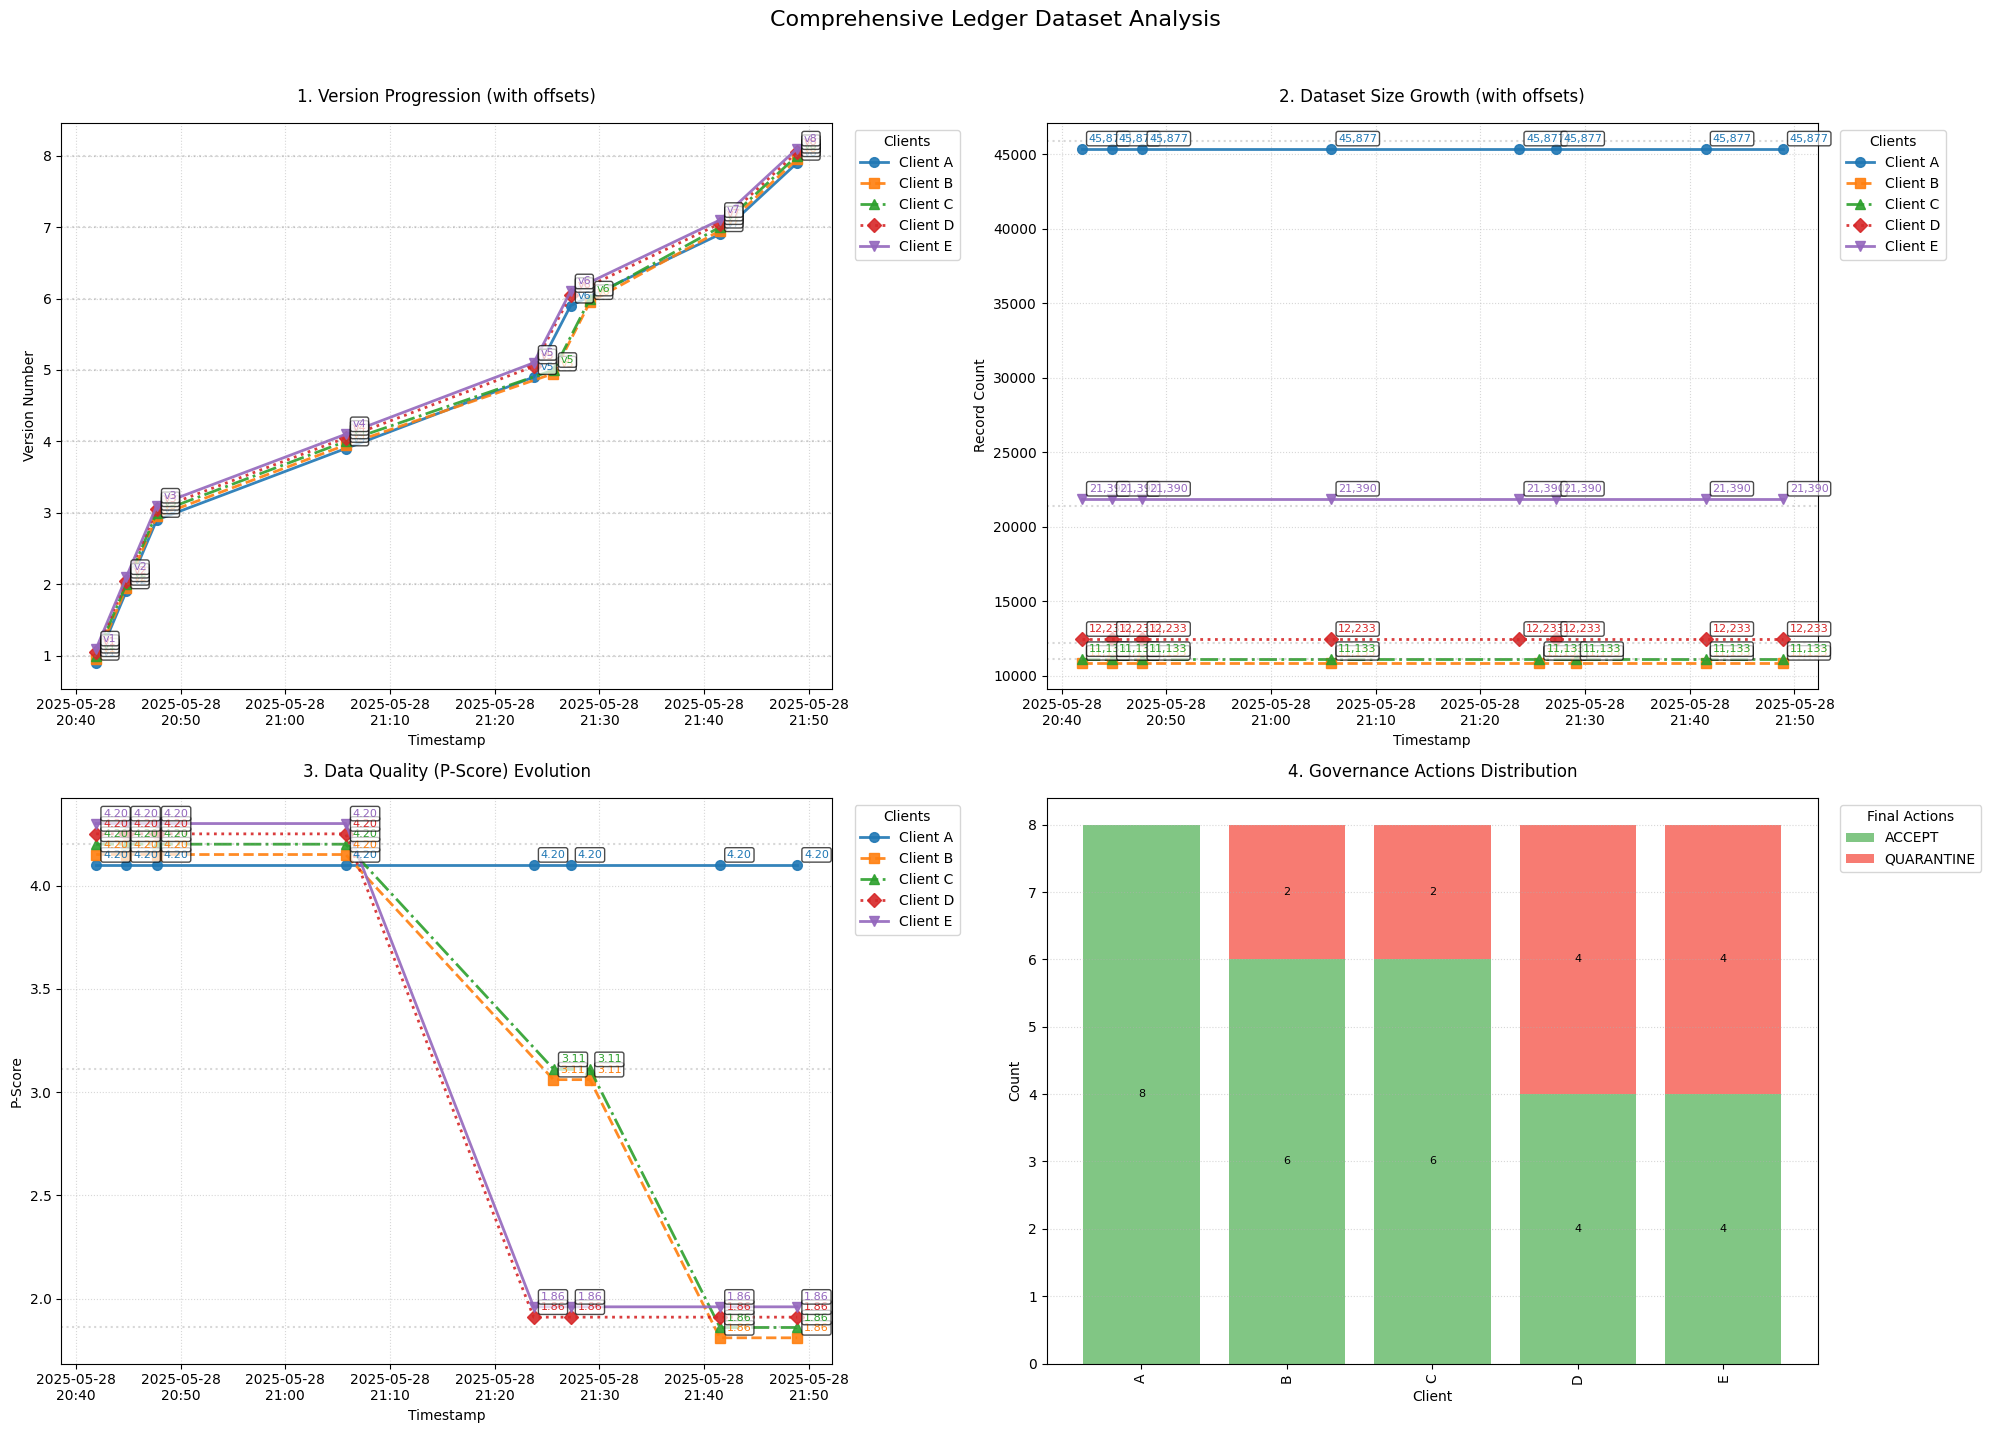

In [ ]:
#──────────────────────────────────────────────────────────────────────────────
# 9.1 Ledgers + Versions over time + Excellent visualizations
#──────────────────────────────────────────────────────────────────────────────

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# 1. Read and merge all ledgers (local and central)
all_data = []
for path in sorted(glob.glob("./ledgers/local/*.csv")):
    df = pd.read_csv(path, parse_dates=["timestamp"])
    df['source'] = 'local'
    all_data.append(df)
try:
    central_df = pd.read_csv("./ledgers/central/central_ledger.csv", parse_dates=["timestamp"])
    central_df['source'] = 'central'
    all_data.append(central_df)
except FileNotFoundError:
    pass

if not all_data:
    print("No ledger files found!")
else:
    # Merge and sort all ledger data
    combined = pd.concat(all_data, ignore_index=True)
    combined = combined.sort_values(['client', 'version', 'timestamp'])

    # Build summary per (client, version)
    group_cols = ['client', 'version']
    result_rows = []
    for (client, version), g in combined.groupby(group_cols):
        # Initial and final actions
        initial_idx = g['timestamp'].idxmin()
        initial_action = g.loc[initial_idx]['action']
        final_idx = g['timestamp'].idxmax()
        final_action = g.loc[final_idx]['action']
        final_row = g.loc[final_idx]

        # Most recent value for features
        def last_non_nan(series):
            return series.dropna().iloc[-1] if not series.dropna().empty else np.nan

        result_rows.append({
            "client": client,
            "version": version,
            "timestamp": final_row['timestamp'],
            "tx_id": final_row.get('tx_id', None),
            "record_count": last_non_nan(g['record_count']),
            "dim1": last_non_nan(g['dim1']),
            "dim2": last_non_nan(g['dim2']),
            "dim3": last_non_nan(g['dim3']),
            "dim4": last_non_nan(g['dim4']),
            "dim5": last_non_nan(g['dim5']),
            "dim6": last_non_nan(g['dim6']),
            "pscore": last_non_nan(g['pscore']),
            "initial_action": initial_action,
            "final_action": final_action,
        })

    summary_df = pd.DataFrame(result_rows)
    summary_df = summary_df.sort_values(['client', 'version'])

    # Display summary table
    print("\nComplete Ledger Data:")
    display(summary_df)

    # (OPTIONAL) Filter: If you want only the 7 main scenarios in scenario-level plots
    # If you want to filter by scenario in scenario tables, do that on analysis_df, NOT here

    # === Ledger Visualizations (per client, version, and actions) ===
    clients = sorted(summary_df['client'].unique())
    line_styles = ['-', '--', '-.', ':'] * 2
    markers = ['o', 's', '^', 'D', 'v', 'p', '*']
    colors = plt.cm.tab10.colors[:len(clients)]

    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle('Comprehensive Ledger Dataset Analysis', y=1.02, fontsize=16)

    # 1. Version Progression
    ax1 = axes[0, 0]
    version_offsets = np.linspace(-0.1, 0.1, len(clients))
    for i, (client, color) in enumerate(zip(clients, colors)):
        client_data = summary_df[summary_df['client'] == client]
        adjusted_versions = client_data['version'] + version_offsets[i]
        ax1.plot(
            client_data['timestamp'],
            adjusted_versions,
            marker=markers[i % len(markers)],
            linestyle=line_styles[i % len(line_styles)],
            markersize=7,
            linewidth=2,
            color=color,
            alpha=0.9,
            label=f'Client {client}'
        )
        for _, row in client_data.iterrows():
            ax1.annotate(
                f"v{row['version']}",
                (row['timestamp'], row['version'] + version_offsets[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8, color=color,
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7)
            )
    ax1.set_title('1. Version Progression (with offsets)', pad=15)
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Version Number')
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    ax1.grid(True, linestyle=':', alpha=0.5)
    ax1.legend(title='Clients', bbox_to_anchor=(1.02, 1), loc='upper left')
    for version in summary_df['version'].unique():
        ax1.axhline(y=version, color='gray', linestyle=':', alpha=0.3)

    # 2. Dataset Size Growth
    ax2 = axes[0, 1]
    count_offsets = np.linspace(-500, 500, len(clients))
    for i, (client, color) in enumerate(zip(clients, colors)):
        client_data = summary_df[summary_df['client'] == client]
        adjusted_counts = client_data['record_count'] + count_offsets[i]
        ax2.plot(
            client_data['timestamp'],
            adjusted_counts,
            marker=markers[i % len(markers)],
            linestyle=line_styles[i % len(line_styles)],
            markersize=7,
            linewidth=2,
            color=color,
            alpha=0.9,
            label=f'Client {client}'
        )
        for _, row in client_data.iterrows():
            ax2.annotate(
                f"{int(row['record_count']):,}" if not pd.isna(row['record_count']) else '',
                (row['timestamp'], row['record_count'] + count_offsets[i] if not pd.isna(row['record_count']) else 0),
                xytext=(5, 5), textcoords='offset points', fontsize=8, color=color,
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7)
            )
    ax2.set_title('2. Dataset Size Growth (with offsets)', pad=15)
    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Record Count')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    ax2.grid(True, linestyle=':', alpha=0.5)
    ax2.legend(title='Clients', bbox_to_anchor=(1.02, 1), loc='upper left')
    for count in summary_df['record_count'].unique():
        ax2.axhline(y=count, color='gray', linestyle=':', alpha=0.3)

    # 3. P-Score Evolution
    ax3 = axes[1, 0]
    if 'pscore' in summary_df.columns:
        score_offsets = np.linspace(-0.1, 0.1, len(clients))
        for i, (client, color) in enumerate(zip(clients, colors)):
            client_data = summary_df[summary_df['client'] == client]
            adjusted_scores = client_data['pscore'] + score_offsets[i]
            ax3.plot(
                client_data['timestamp'],
                adjusted_scores,
                marker=markers[i % len(markers)],
                linestyle=line_styles[i % len(line_styles)],
                markersize=7,
                linewidth=2,
                color=color,
                alpha=0.9,
                label=f'Client {client}'
            )
            for _, row in client_data.iterrows():
                ax3.annotate(
                    f"{row['pscore']:.2f}" if not pd.isna(row['pscore']) else '',
                    (row['timestamp'], row['pscore'] + score_offsets[i] if not pd.isna(row['pscore']) else 0),
                    xytext=(5, 5), textcoords='offset points', fontsize=8, color=color,
                    bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7)
                )
        ax3.set_title('3. Data Quality (P-Score) Evolution', pad=15)
        ax3.set_xlabel('Timestamp')
        ax3.set_ylabel('P-Score')
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
        ax3.grid(True, linestyle=':', alpha=0.5)
        ax3.legend(title='Clients', bbox_to_anchor=(1.02, 1), loc='upper left')
        for score in summary_df['pscore'].unique():
            ax3.axhline(y=score, color='gray', linestyle=':', alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'P-Score data not available', ha='center', va='center', fontsize=12)
        ax3.set_title('3. Data Quality Metrics', pad=15)

    # 4. Action Distribution
    ax4 = axes[1, 1]
    if 'final_action' in summary_df.columns:
        action_counts = summary_df.groupby(['client', 'final_action']).size().unstack(fill_value=0)
        action_colors = {
            'ACCEPT': '#4CAF50',      # Green
            'REVIEW': '#FFC107',      # Yellow
            'QUARANTINE': '#F44336'   # Red
        }
        # Only plot actions that exist
        actions_to_plot = [a for a in action_colors if a in action_counts.columns]
        action_counts[actions_to_plot].plot(
            kind='bar', stacked=True, ax=ax4,
            color=[action_colors[a] for a in actions_to_plot], alpha=0.7, width=0.8
        )
        for p in ax4.patches:
            if p.get_height() > 0:
                ax4.annotate(
                    int(p.get_height()),
                    (p.get_x() + p.get_width()/2., p.get_y() + p.get_height()/2),
                    ha='center', va='center', color='black', fontsize=8
                )
        ax4.set_title('4. Governance Actions Distribution', pad=15)
        ax4.set_xlabel('Client')
        ax4.set_ylabel('Count')
        ax4.legend(title='Final Actions', bbox_to_anchor=(1.02, 1))
        ax4.grid(True, linestyle=':', alpha=0.5, axis='y')
    else:
        ax4.text(0.5, 0.5, 'Action data not available', ha='center', va='center', fontsize=12)
        ax4.set_title('4. Governance Actions', pad=15)

    plt.tight_layout()
    plt.show()


Initial Actions by Client:
 initial_action  ACCEPT  QUARANTINE  REVIEW
client                                    
A                    8           0       0
B                    4           2       2
C                    4           2       2
D                    4           4       0
E                    4           4       0
Final Actions by Client:
 final_action  ACCEPT  QUARANTINE
client                          
A                  8           0
B                  6           2
C                  6           2
D                  4           4
E                  4           4


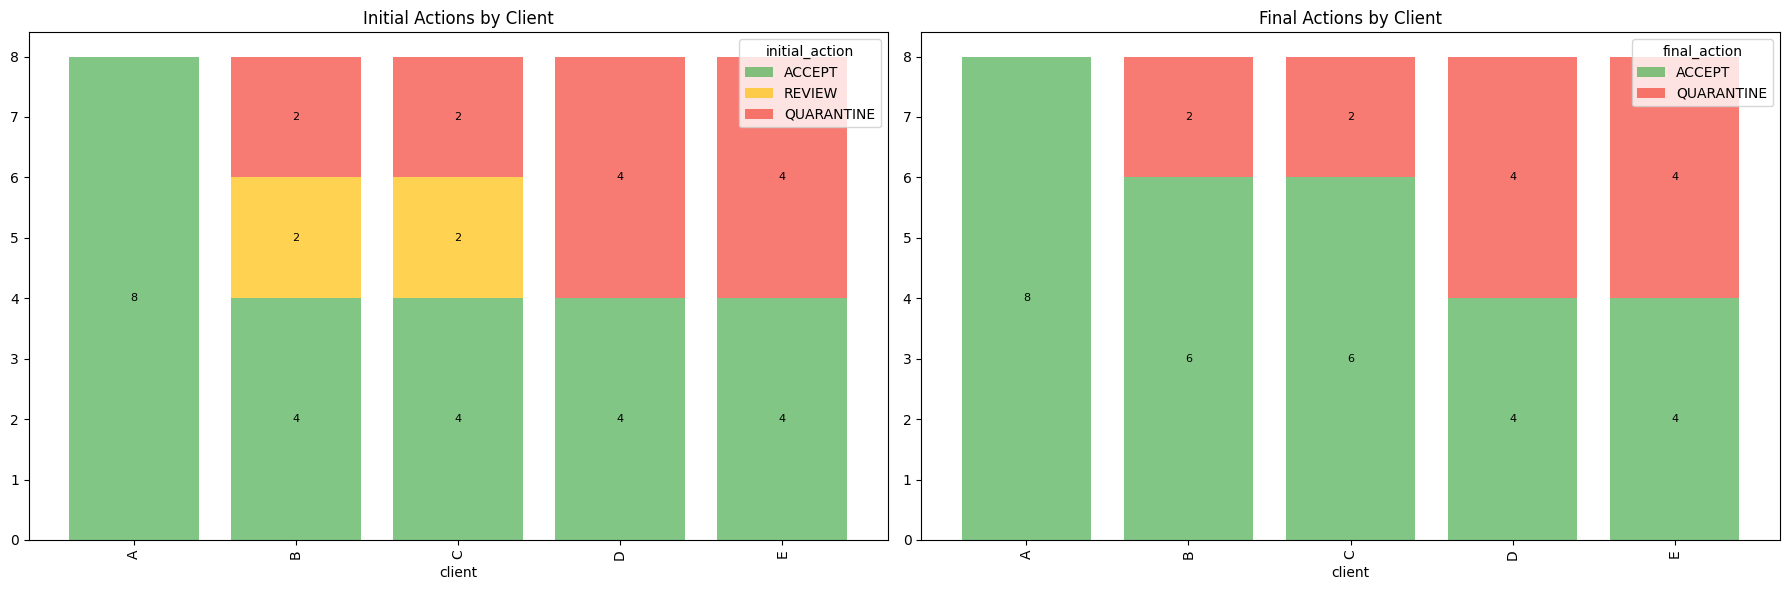

In [ ]:
# Existing summary_df already has initial_action and final_action per version
# Initial action count (e.g., how many started as REVIEW)
initial_counts = summary_df.groupby(['client', 'initial_action']).size().unstack(fill_value=0)
# Final action count (e.g., how many ended as ACCEPT)
final_counts = summary_df.groupby(['client', 'final_action']).size().unstack(fill_value=0)

print("Initial Actions by Client:\n", initial_counts)
print("Final Actions by Client:\n", final_counts)

# Plot initial actions
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
action_colors = {'ACCEPT': '#4CAF50', 'REVIEW': '#FFC107', 'QUARANTINE': '#F44336'}
actions_to_plot_init = [a for a in action_colors if a in initial_counts.columns]
actions_to_plot_final = [a for a in action_colors if a in final_counts.columns]
initial_counts[actions_to_plot_init].plot(kind='bar', stacked=True, ax=axes[0],
    color=[action_colors[a] for a in actions_to_plot_init], alpha=0.7, width=0.8)
final_counts[actions_to_plot_final].plot(kind='bar', stacked=True, ax=axes[1],
    color=[action_colors[a] for a in actions_to_plot_final], alpha=0.7, width=0.8)
axes[0].set_title('Initial Actions by Client')
axes[1].set_title('Final Actions by Client')
for ax in axes:
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(int(p.get_height()), (p.get_x() + p.get_width()/2., p.get_y() + p.get_height()/2), ha='center', va='center', color='black', fontsize=8)
plt.tight_layout()
plt.show()


<Figure size 1800x1600 with 0 Axes>

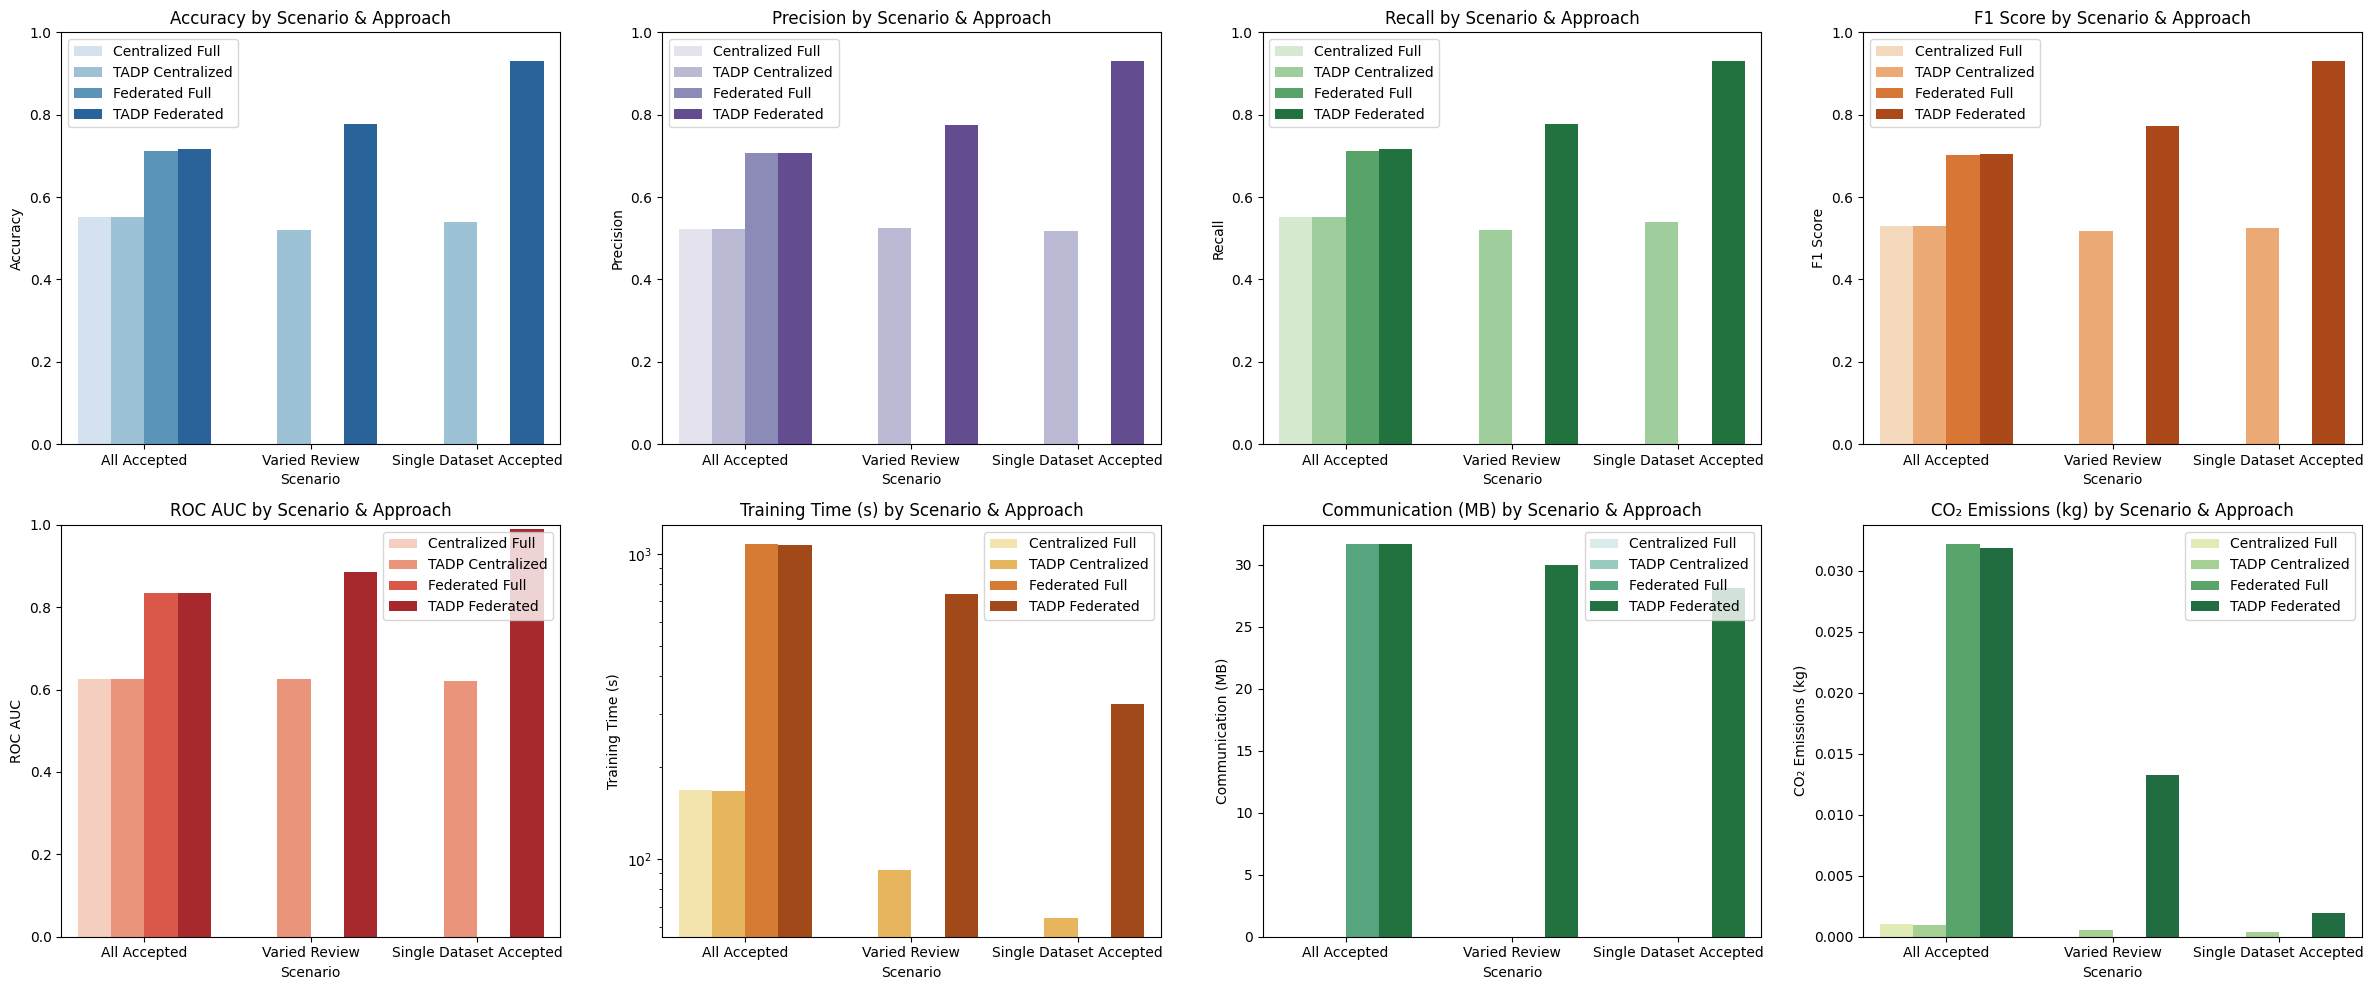

In [ ]:
#──────────────────────────────────────────────────────────────────────────────
# Cell 8.2: PERFORMANCE & SUSTAINABILITY ANALYSIS
# ──────────────────────────────────────────────────────────────────────────────

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 16))
metrics_palettes = {
    'accuracy': 'Blues',
    'precision': 'Purples',
    'recall': 'Greens',
    'f1': 'Oranges',
    'roc_auc': 'Reds',
    'Time_s': 'YlOrBr',
    'Comm_MB': 'BuGn',
    'CO2_kg': 'YlGn'
}

metric_titles = {
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'f1': 'F1 Score',
    'roc_auc': 'ROC AUC',
    'Time_s': 'Training Time (s)',
    'Comm_MB': 'Communication (MB)',
    'CO2_kg': 'CO₂ Emissions (kg)'
}

# Metrics to plot
metric_list = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'Time_s', 'Comm_MB', 'CO2_kg']
num_metrics = len(metric_list)
rows = 2
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(24, 10))
axes = axes.flatten()

for i, metric in enumerate(metric_list):
    if metric in analysis_df.columns:
        sns.barplot(
            ax=axes[i],
            data=analysis_df,
            x='Scenario',
            y=metric,
            hue='Approach',
            palette=metrics_palettes.get(metric, 'Blues')
        )
        axes[i].set_title(f'{metric_titles[metric]} by Scenario & Approach')
        axes[i].set_xlabel('Scenario')
        axes[i].set_ylabel(metric_titles[metric])
        if metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            axes[i].set_ylim(0, 1)
        if metric == 'Time_s':
            axes[i].set_yscale('log')
        axes[i].legend(loc='best')
    else:
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()


<ipython-input-19-81d401087c91>:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=mean, x=x, y=y, hue=hue, ci=None)


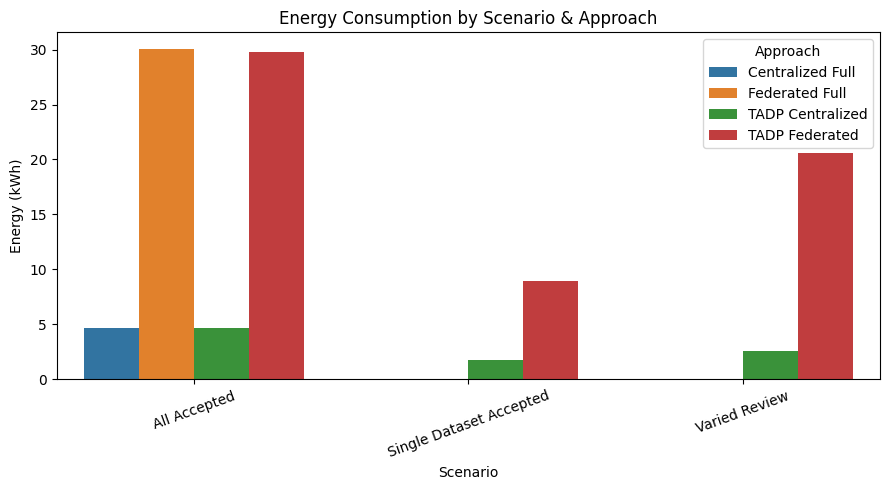

<ipython-input-19-81d401087c91>:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=mean, x=x, y=y, hue=hue, ci=None)


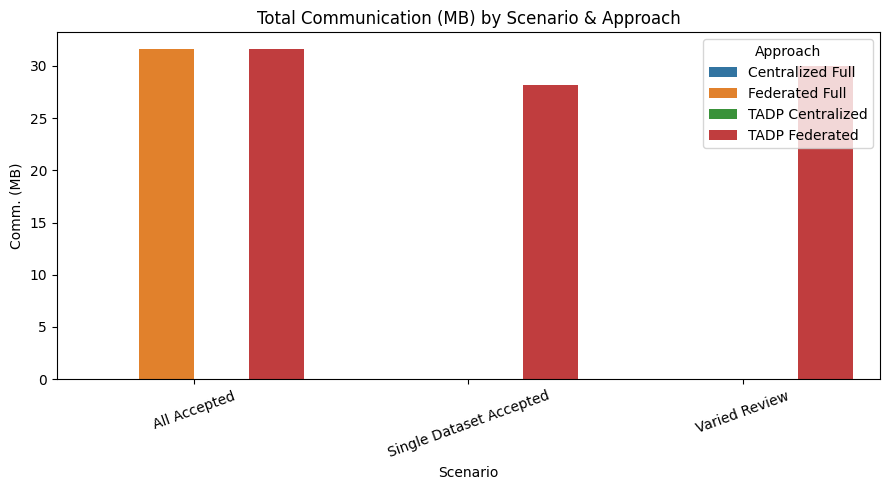

<ipython-input-19-81d401087c91>:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=mean, x=x, y=y, hue=hue, ci=None)


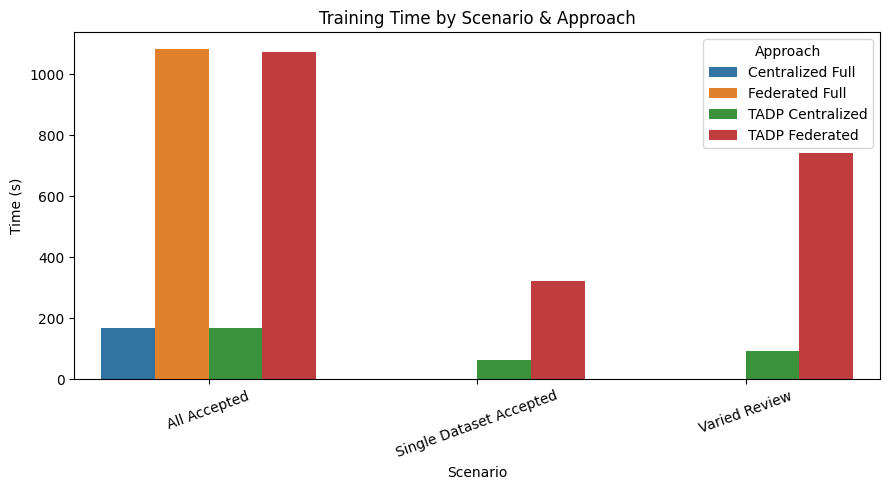

<ipython-input-19-81d401087c91>:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=mean, x=x, y=y, hue=hue, ci=None)


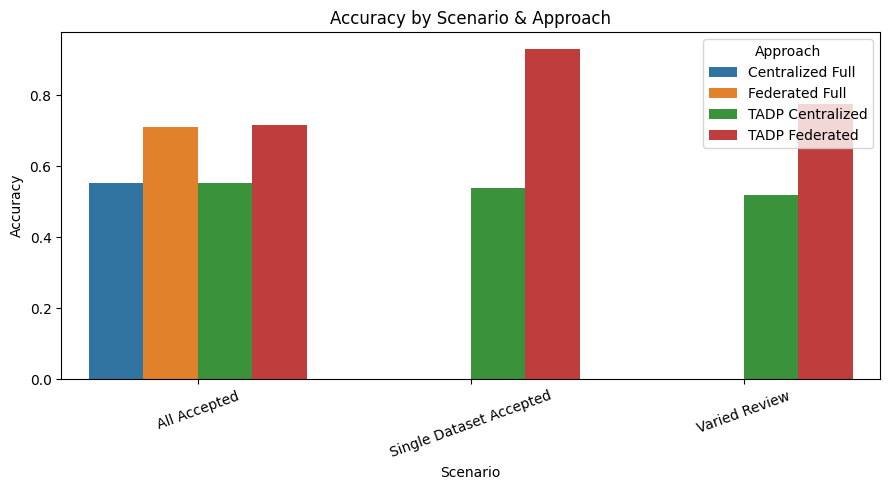

<ipython-input-19-81d401087c91>:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=mean, x=x, y=y, hue=hue, ci=None)


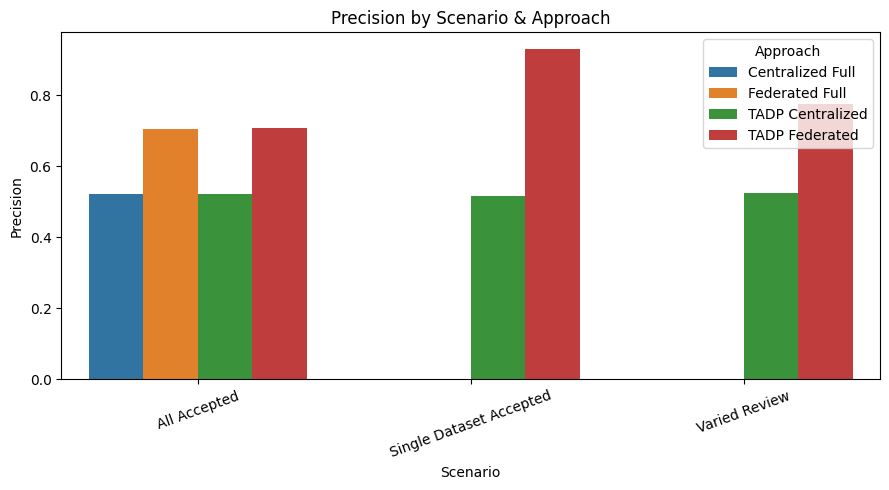

<ipython-input-19-81d401087c91>:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=mean, x=x, y=y, hue=hue, ci=None)


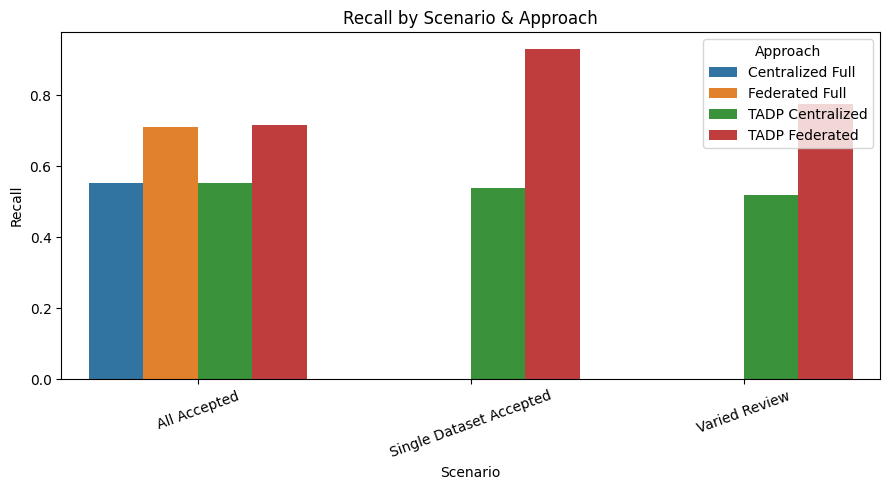

<ipython-input-19-81d401087c91>:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=mean, x=x, y=y, hue=hue, ci=None)


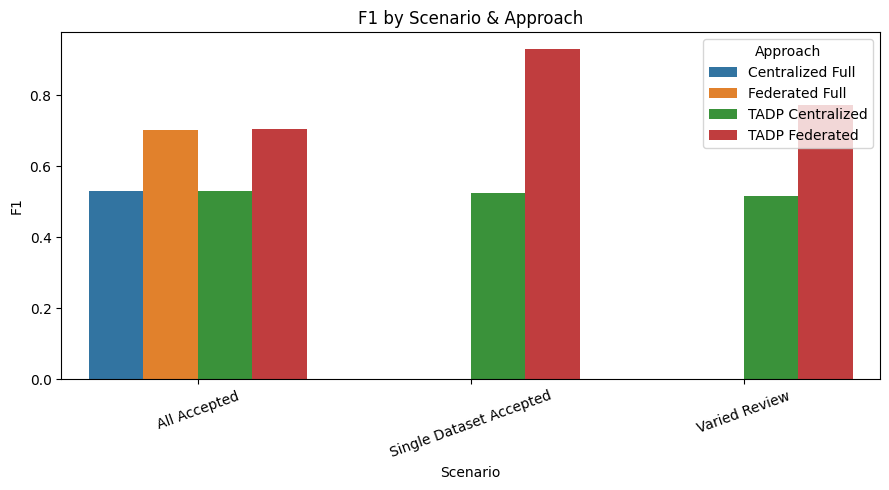

<ipython-input-19-81d401087c91>:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=mean, x=x, y=y, hue=hue, ci=None)


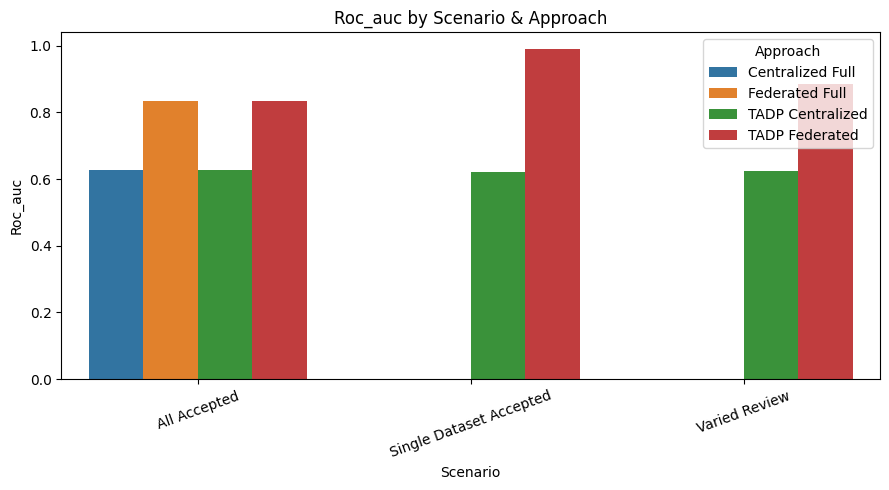


=== Summary: Energy & Cost ===


mean                \
                                         Communication_MB Energy_Cost_$   
Scenario                Approach                                          
All Accepted            Centralized Full         0.000000      0.469345   
                        Federated Full          31.640968      3.006950   
                        TADP Centralized         0.000000      0.464652   
                        TADP Federated          31.640968      2.979618   
Single Dataset Accepted TADP Centralized         0.000000      0.178408   
                        TADP Federated          28.154640      0.897817   
Varied Review           TADP Centralized         0.000000      0.256912   
                        TADP Federated          29.985695      2.060559   

                                                                  
                                         Energy_kWh Train_Time_s  
Scenario                Approach                                  
All Accepted            Centralized Full   4.693452   168.964270  
                        Federated Full    30.069496  1082.501873  
                        TADP Centralized   4.646525   167.274899  
                        TADP Federated    29.796178  1072.662393  
Single Dataset Accepted TADP Centralized   1.784078    64.226801  
                        TADP Federated     8.978172   323.214184  
Varied Review           TADP Centralized   2.569120    92.488312  
                        TADP Federated    20.605595   741.801417


=== Summary: Performance Metrics ===


mean                      \
                                          accuracy        f1 precision   
Scenario                Approach                                         
All Accepted            Centralized Full  0.552864  0.530267  0.521610   
                        Federated Full    0.711899  0.702694  0.706051   
                        TADP Centralized  0.552864  0.530267  0.521610   
                        TADP Federated    0.715682  0.704215  0.708155   
Single Dataset Accepted TADP Centralized  0.540105  0.524601  0.517474   
                        TADP Federated    0.931343  0.930862  0.931069   
Varied Review           TADP Centralized  0.520434  0.516896  0.525232   
                        TADP Federated    0.777093  0.771901  0.774244   

                                                              
                                            recall   roc_auc  
Scenario                Approach                              
All Accepted            Centralized Full  0.552864  0.626594  
                        Federated Full    0.711899  0.834350  
                        TADP Centralized  0.552864  0.626594  
                        TADP Federated    0.715682  0.834312  
Single Dataset Accepted TADP Centralized  0.540105  0.620072  
                        TADP Federated    0.931343  0.990277  
Varied Review           TADP Centralized  0.520434  0.625386  
                        TADP Federated    0.777093  0.885731

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ── 1) PARAMETERS & HELPERS ─────────────────────────────────────────
POWER_W      = 100.0    # average training power draw [W]
COST_PER_KWH = 0.10     # $ per kWh
NUM_ROUNDS   = NUM_ROUNDS_FL  # e.g. 3

def get_approach_label(is_tadp, model_type):
    if not is_tadp and model_type=='centralized':
        return "Centralized Full"
    if not is_tadp and model_type=='federated':
        return "Federated Full"
    if  is_tadp and model_type=='centralized':
        return "TADP Centralized"
    if  is_tadp and model_type=='federated':
        return "TADP Federated"
    return model_type

# ── 2) BUILD COMPARISON DATAFRAME ────────────────────────────────────
records = []
for (scenario_name, run_type), entry in results.items():
    # scenario_name is like "All Accepted", run_type like "Centralized Full"
    # but we recompute run_type for clarity
    approach = get_approach_label(entry['is_tadp'], entry['model_type'])
    label    = scenario_name  # e.g. "All Accepted", "Varied Review", etc.

    # base metrics
    metrics = entry['metrics']  # dict keys: 'accuracy','precision','recall','f1','roc_auc'

    # approximate model size in MB (4 bytes per param)
    model_mb = entry['param_count'] * 4 / (1024**2)

    # communication: only for federated approaches
    comm_mb = model_mb * NUM_ROUNDS * 2 if entry['model_type']=='federated' else 0.0

    records.append({
        "Scenario":      label,
        "Approach":      approach,
        **{m: metrics[m] for m in METRICS},
        "Train_Time_s":  entry['train_time'],
        "Rounds":        (NUM_ROUNDS if entry['model_type']=='federated' else 1),
        "Communication_MB": comm_mb
    })

cmp_df = pd.DataFrame(records)

# compute energy & cost
cmp_df["Energy_kWh"]  = (cmp_df["Train_Time_s"] * POWER_W) / 3600.0
cmp_df["Energy_Cost_$"] = cmp_df["Energy_kWh"] * COST_PER_KWH

# ── 3) FUNCTION TO PLOT WITH ERROR BARS ─────────────────────────────
def bar_with_errors(df, x, y, hue, title, ylabel):
    """
    Group by x & hue, compute mean ± sem, plot bar+errorbar.
    """
    grp = df.groupby([x, hue])[y]
    mean = grp.mean().reset_index()
    count= grp.count().reset_index()[y]
    std  = grp.std().fillna(0).reset_index()[y]
    sem  = std / np.sqrt(count)
    sem[count<=1] = 0  # no error bar if only one sample

    plt.figure(figsize=(9,5))
    ax = sns.barplot(data=mean, x=x, y=y, hue=hue, ci=None)
    for i, row in mean.iterrows():
        err = sem.iloc[i]
        if err>0:
            ax.errorbar(i, row[y], yerr=err, color='black', capsize=3)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(x)
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

# ── 4) PLOT ENERGY CONSUMPTION ──────────────────────────────────────
bar_with_errors(
    cmp_df,
    x="Scenario",
    y="Energy_kWh",
    hue="Approach",
    title="Energy Consumption by Scenario & Approach",
    ylabel="Energy (kWh)"
)

# ── 5) PLOT COMMUNICATION OVERHEAD ──────────────────────────────────
bar_with_errors(
    cmp_df,
    x="Scenario",
    y="Communication_MB",
    hue="Approach",
    title="Total Communication (MB) by Scenario & Approach",
    ylabel="Comm. (MB)"
)

# ── 6) PLOT TRAINING TIME ───────────────────────────────────────────
bar_with_errors(
    cmp_df,
    x="Scenario",
    y="Train_Time_s",
    hue="Approach",
    title="Training Time by Scenario & Approach",
    ylabel="Time (s)"
)

# ── 7) PERFORMANCE METRICS ─────────────────────────────────────────
for metric in METRICS:
    bar_with_errors(
        cmp_df,
        x="Scenario",
        y=metric,
        hue="Approach",
        title=f"{metric.capitalize()} by Scenario & Approach",
        ylabel=metric.capitalize()
    )

# ── 8) PRINT SUMMARY TABLES ─────────────────────────────────────────
print("\n=== Summary: Energy & Cost ===")
energy_tbl = cmp_df.pivot_table(
    index=["Scenario","Approach"],
    values=["Energy_kWh","Energy_Cost_$","Communication_MB","Train_Time_s"],
    aggfunc=["mean","std"]
)
display(energy_tbl)

print("\n=== Summary: Performance Metrics ===")
perf_tbl = cmp_df.pivot_table(
    index=["Scenario","Approach"],
    values=METRICS,
    aggfunc=["mean","std"]
)
display(perf_tbl)


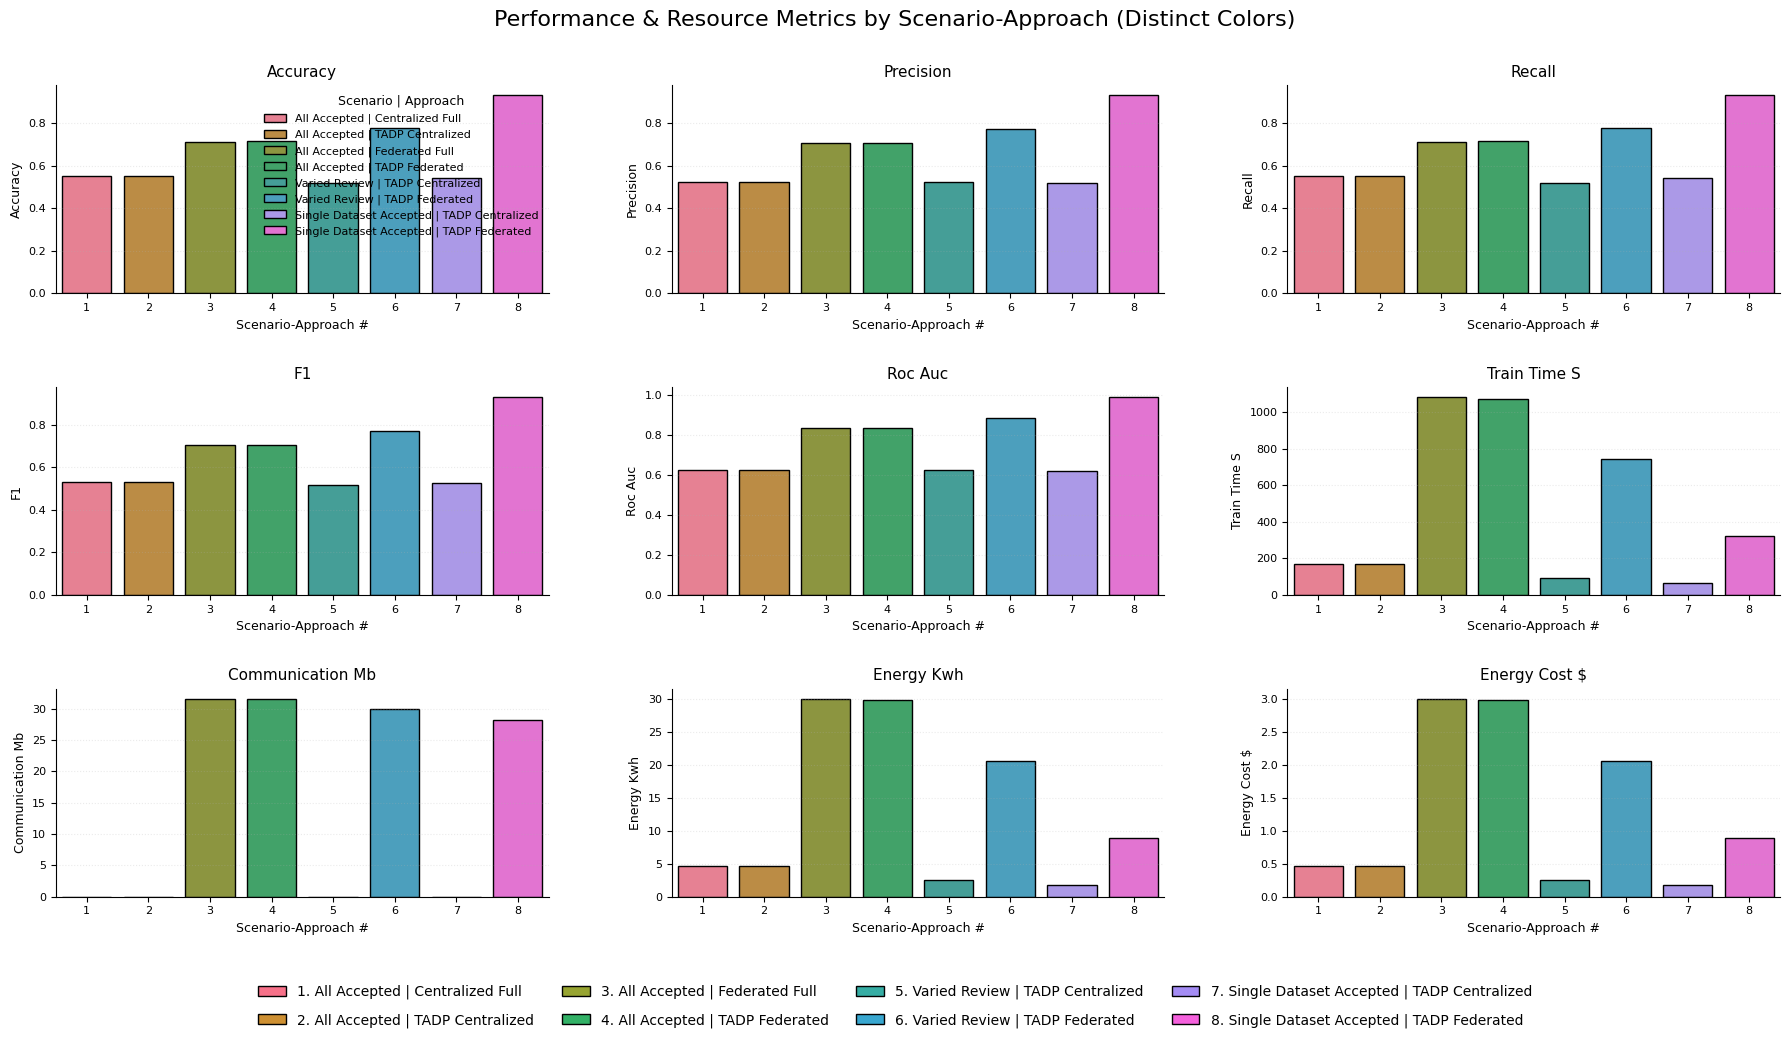

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Setup: orderings
scenario_order = ['All Accepted', 'Varied Review', 'Single Dataset Accepted']
cmp_df["Scenario"] = pd.Categorical(cmp_df["Scenario"], categories=scenario_order, ordered=True)
cmp_df["Approach"] = cmp_df["Approach"].astype(str)
cmp_df["Scenario_Approach"] = cmp_df["Scenario"].astype(str) + " | " + cmp_df["Approach"].astype(str)
scenario_approach_order = cmp_df["Scenario_Approach"].unique().tolist()
cmp_df["Scenario_Approach"] = pd.Categorical(cmp_df["Scenario_Approach"], scenario_approach_order, ordered=True)

# Numeric labels for compact x-axis
cmp_df = cmp_df.sort_values(["Scenario", "Approach"])
label_map = {sa: str(i+1) for i, sa in enumerate(scenario_approach_order)}
cmp_df["SA_Label"] = cmp_df["Scenario_Approach"].map(label_map)

# Assign color to each **Scenario-Approach** (so every bar is unique, not just by approach)
num_combos = len(scenario_approach_order)
unique_palette = sns.color_palette("husl", num_combos)
combo_palette = dict(zip(scenario_approach_order, unique_palette))

# Metrics
metrics_to_plot = [
    "accuracy", "precision", "recall", "f1", "roc_auc",
    "Train_Time_s", "Communication_MB", "Energy_kWh", "Energy_Cost_$"
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    # Each bar colored by scenario-approach combo
    sns.barplot(
        data=cmp_df,
        x="SA_Label",
        y=metric,
        hue="Scenario_Approach",
        hue_order=scenario_approach_order,
        palette=combo_palette,
        ax=ax,
        dodge=False,
        edgecolor='black'
    )
    ax.set_title(metric.replace("_", " ").title(), fontsize=11, pad=6)
    ax.set_xlabel("Scenario-Approach #", fontsize=9)
    ax.set_ylabel(metric.replace("_", " ").title(), fontsize=9)
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)
    ax.grid(axis="y", linestyle=":", alpha=0.25)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    # Hide legends on all but one plot
    if i == 0:
        ax.legend(title="Scenario | Approach", fontsize=8, title_fontsize=9, loc="best", frameon=False)
    else:
        ax.get_legend().remove()

# Remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout(rect=[0, 0.08, 1, 0.98])
fig.subplots_adjust(wspace=0.25, hspace=0.45)
fig.suptitle("Performance & Resource Metrics by Scenario-Approach (Distinct Colors)", fontsize=16, y=1.02)

# Custom legend with colors and numbers
handles = []
for sa in scenario_approach_order:
    color = combo_palette[sa]
    label = f'{label_map[sa]}. {sa}'
    handles.append(Patch(facecolor=color, edgecolor='black', label=label))
plt.figlegend(
    handles=handles,
    loc='lower center',
    ncol=4,
    labelspacing=1.0,
    fontsize=10,
    frameon=False,
    bbox_to_anchor=(0.5, -0.01)
)
plt.show()


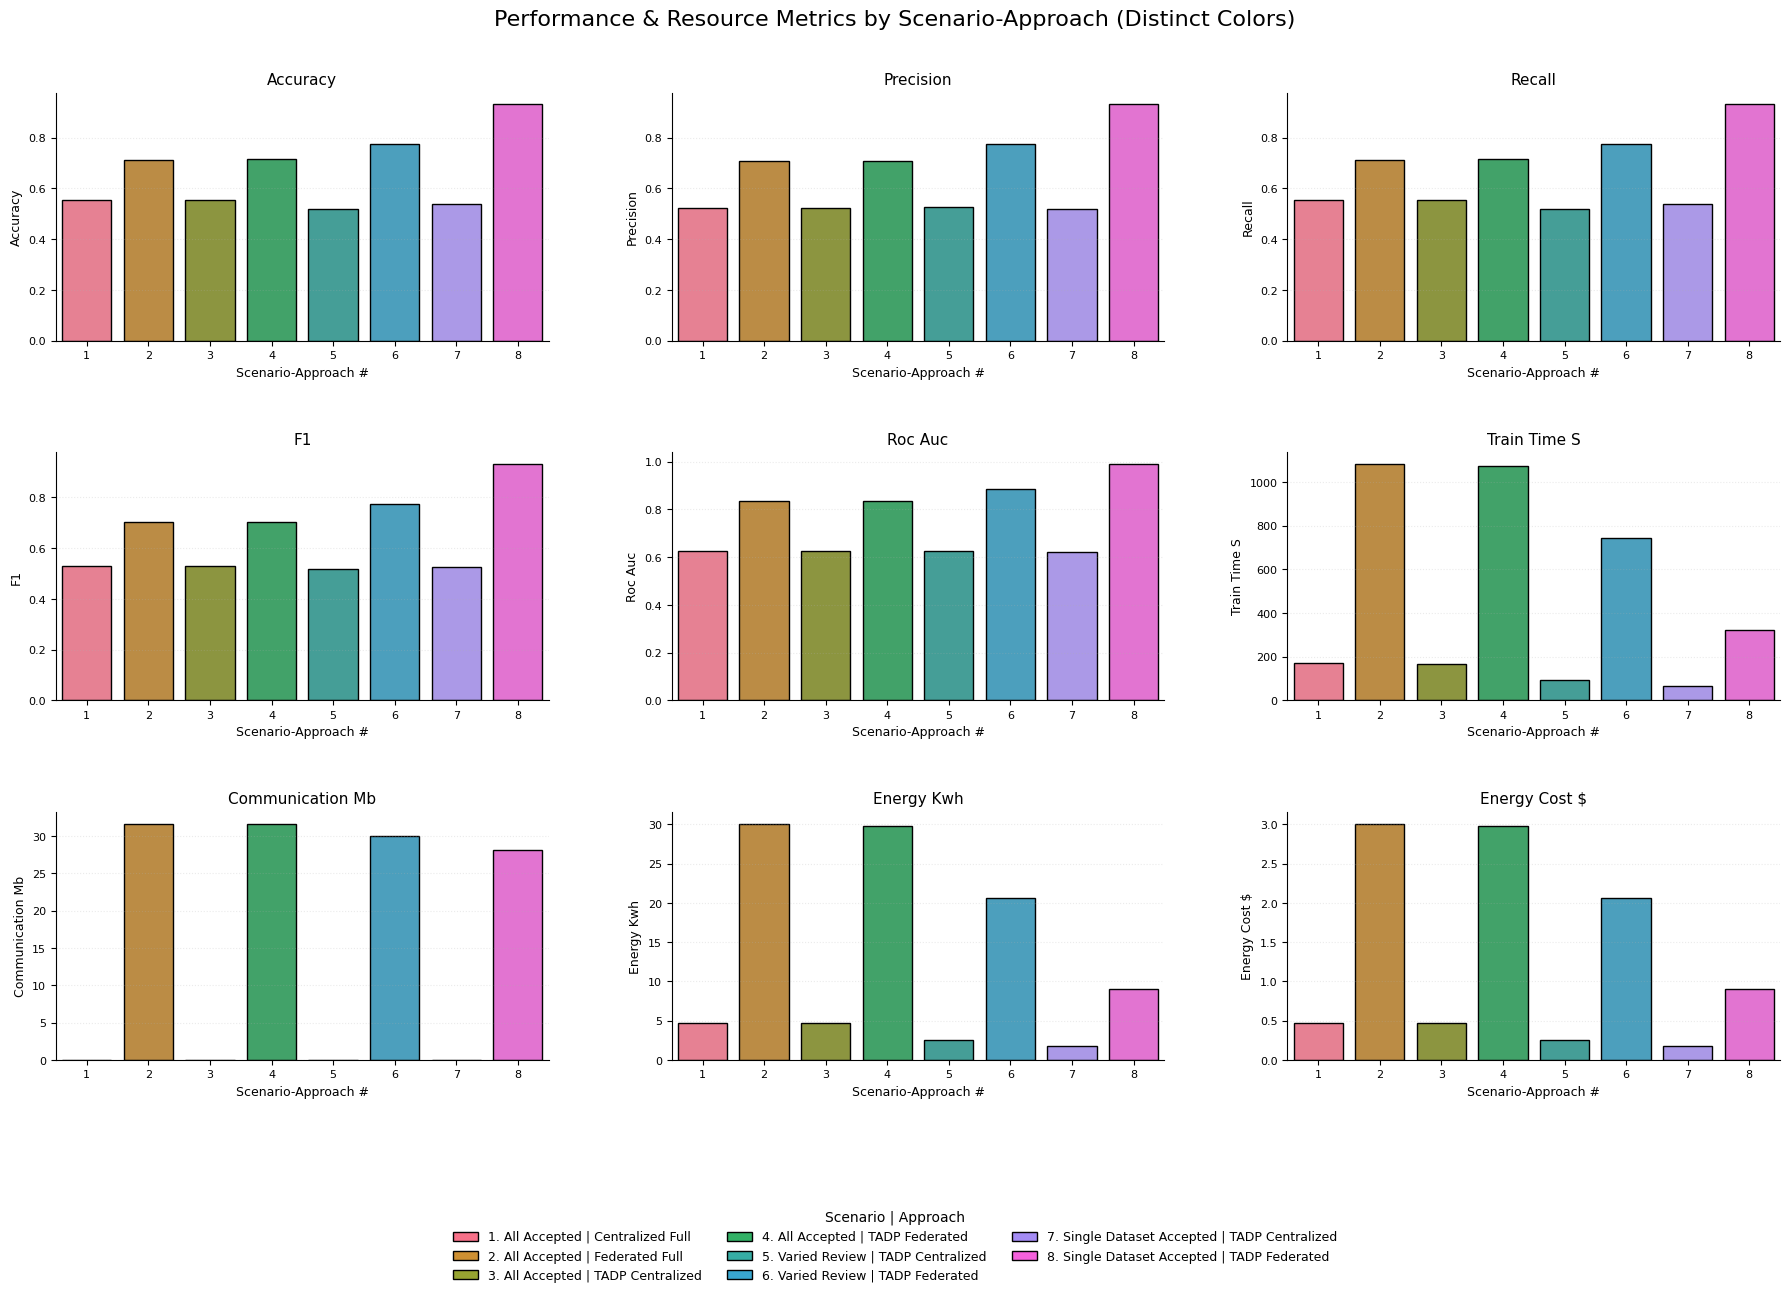

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Setup: orderings
scenario_order = ['All Accepted', 'Varied Review', 'Single Dataset Accepted']
cmp_df["Scenario"] = pd.Categorical(cmp_df["Scenario"], categories=scenario_order, ordered=True)
cmp_df["Approach"] = cmp_df["Approach"].astype(str)
cmp_df["Scenario_Approach"] = cmp_df["Scenario"].astype(str) + " | " + cmp_df["Approach"].astype(str)
scenario_approach_order = cmp_df["Scenario_Approach"].unique().tolist()
cmp_df["Scenario_Approach"] = pd.Categorical(cmp_df["Scenario_Approach"], scenario_approach_order, ordered=True)

# Numeric labels for compact x-axis
cmp_df = cmp_df.sort_values(["Scenario", "Approach"])
label_map = {sa: str(i+1) for i, sa in enumerate(scenario_approach_order)}
cmp_df["SA_Label"] = cmp_df["Scenario_Approach"].map(label_map)

# Assign color to each Scenario-Approach
num_combos = len(scenario_approach_order)
unique_palette = sns.color_palette("husl", num_combos)
combo_palette = dict(zip(scenario_approach_order, unique_palette))

# Metrics
metrics_to_plot = [
    "accuracy", "precision", "recall", "f1", "roc_auc",
    "Train_Time_s", "Communication_MB", "Energy_kWh", "Energy_Cost_$"
]

# Create figure with extra space at bottom for legend
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.barplot(
        data=cmp_df,
        x="SA_Label",
        y=metric,
        hue="Scenario_Approach",
        hue_order=scenario_approach_order,
        palette=combo_palette,
        ax=ax,
        dodge=False,
        edgecolor='black'
    )
    ax.set_title(metric.replace("_", " ").title(), fontsize=11, pad=6)
    ax.set_xlabel("Scenario-Approach #", fontsize=9)
    ax.set_ylabel(metric.replace("_", " ").title(), fontsize=9)
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)
    ax.grid(axis="y", linestyle=":", alpha=0.25)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    # Remove all individual legends
    ax.get_legend().remove()

# Remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Create custom legend with colors and numbers
handles = []
for sa in scenario_approach_order:
    color = combo_palette[sa]
    label = f'{label_map[sa]}. {sa}'
    handles.append(Patch(facecolor=color, edgecolor='black', label=label))

# Add legend below all subplots
fig.legend(
    handles=handles,
    loc='lower center',
    ncol=3,  # Adjust number of columns based on your legend items
    fontsize=9,
    frameon=False,
    bbox_to_anchor=(0.5, -0.05),  # Adjust vertical position as needed
    title="Scenario | Approach",
    title_fontsize=10
)

# Adjust layout to make space for legend
fig.tight_layout(rect=[0, 0.1, 1, 0.98])  # Adjust bottom margin (0.1) as needed
fig.subplots_adjust(wspace=0.25, hspace=0.45)
fig.suptitle("Performance & Resource Metrics by Scenario-Approach (Distinct Colors)", fontsize=16, y=1.02)

plt.show()